In [1]:
#install packages
import idaes
import pyomo.environ as pyo
import numpy as np
import math
import csv
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from membrane_reactor_v2 import toggle_reaction_off
from membrane_reactor_v2 import toggle_reaction_on
from membrane_reactor_v2 import init_reaction_rate
from membrane_reactor_v2 import pressure_sensitivity
from membrane_reactor_v2 import plot_pd
from membrane_reactor_v2 import CO_conversion
from membrane_reactor_v2 import H2_recovery
from membrane_reactor_v2 import feed_utilization_efficiency
from membrane_reactor_v2 import create_model
from membrane_reactor_v2 import conc_profile_multiple



In [2]:
# Specify case based on input dataset.
# # PCI-10: bench-scale laboratory  data supplied by PCI - 
# # PCI-H2A: bench-scale laboratory data on membrane performance combined with industrial gas properties from the NREL H2A model report - 
# #            corresponds to dataset in Table 3 in paper
# # public: data published in Brunetti 2007 https://doi.org/10.1016/j.memsci.2007.09.009
# # public-H2A: membrane perfromance data from Brunetti 2007 combined with industrial gas properties from the NREL H2A model report

case = 'PCI-H2A'

# options
save_data = False
save_fig=True
LOUD = True

In [3]:
# read data from json file
data_path = 'WGSMR_data_{}'.format(case)
with open(data_path, 'r') as source_file:
    data = json.load(source_file)

In [4]:
Tmin = 573
Tmax = 800
GHSVmin = 500
GHSVmax = 3000

## GHSV and Temperature optimization (uniform temperature)

In [5]:
optimization = True

In [6]:
# optimization
if optimization:
    
    Tmin = 573
    Tmax = 800
    GHSVmin = 500
    GHSVmax = 3000

    m2 = create_model(temp_retentate=data['temp_retentate'],
                    CO_comp_feed=data['CO_comp_feed'],
                    H2O_comp_feed=data['H2O_comp_feed'],
                    CO2_comp_feed=data['CO2_comp_feed'],
                    H2_comp_feed=data['H2_comp_feed'],
                    feed_flow = data['feed_flow'],
                    CH4_comp_feed=data['CH4_comp_feed'],
                    N2_comp_feed=data['N2_comp_feed'],
                    feed_pressure=data['feed_pressure'],
                    pressure_drop_retentate=data['pressure_drop_retentate'],
                    sweep_pressure=data['sweep_pressure'],
                    pre_exponent=data['pre_exponent'],
                    E_R=data['E_R'],
                    feed_input_mode='GHSV',
                    pressure_exponent=data['pressure_exponent'],
                    vol_reactor=data['vol_reactor'],
                    area_membrane=data['area_membrane'],
                    rho_catalyst=data['rho_catalyst'],
                    T_lb=Tmin,
                    T_ub=Tmax,
                    GHSV_lb=GHSVmin,
                    GHSV_ub=GHSVmax,
                    separate_temperatures=False)
    solver = pyo.SolverFactory('ipopt')
    # deactivate reaction
    toggle_reaction_off(m2)
    results = solver.solve(m2, tee=False)

    # toggle reaction on
    toggle_reaction_on(m2)
    # initialize reaction rate
    init_reaction_rate(m2)
    solver.solve(m2,tee=True)


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  86 -4.1558024e-01 1.28e+01 9.28e+05  -1.0 4.19e+02    -  5.31e-01 3.05e-01w  1
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 37275 to 74550 and la from 58665 to 121788 and factorize again.
  87 -4.1746057e-01 1.51e-01 2.74e+06  -1.0 4.22e+02    -  3.10e-01 3.87e-03h  8
  88 -4.1745620e-01 1.50e-01 3.14e+06  -1.0 3.68e+02    -  1.00e+00 3.59e-03h  9
  89 -4.1745256e-01 1.50e-01 3.24e+06  -1.0 2.20e+02    -  3.08e-01 3.87e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -4.1744808e-01 1.50e-01 3.61e+06  -1.0 3.55e+02    -  1.00e+00 3.61e-03h  9
  91 -4.1744437e-01 1.49e-01 3.71e+06  -1.0 2.09e+02    -  3.21e-01 3.87e-03h  9
  92 -4.1743977e-01 1.49e-01 4.04e+06  -1.0 3.32e+02    -  1.00e+00 3.70e-03h  9
  93 -4.1743583e-01 1.49e-01 4.13e+06  -1.0 2.18e+02    -  3.20e-01 3.87e-03h  9
  94 -4.1743112e-01 1.48e-01 4.44e+06  -1.0 3.25e+02    -  1.00e+00 3.68e-03h  9
  95 -4.1742706e-01 1.48e-01 4.52e+06  -1.0 2.13e+02    

 181 -4.1779957e-01 2.12e-07 6.30e+04  -5.7 3.64e-10  14.2 1.00e+00 1.00e+00h  1
 182 -4.1779957e-01 2.80e-11 3.54e+08  -5.7 1.21e-07  13.8 1.00e+00 1.00e+00h  1
 183 -4.1779957e-01 2.17e-11 3.53e+08  -8.6 9.42e-02    -  7.19e-01 9.77e-04h 11
 184 -4.1779957e-01 2.03e-11 3.53e+08  -8.6 9.42e-02    -  9.33e-01 4.88e-04h 12
 185 -4.1779957e-01 2.01e-11 3.53e+08  -8.6 9.42e-02    -  1.00e+00 1.22e-04h 14
 186 -4.1779957e-01 2.01e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 1.53e-05h 17
 187 -4.1779957e-01 2.00e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 7.63e-06h 18
 188 -4.1779957e-01 2.00e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 1.53e-05h 17
 189 -4.1779957e-01 1.99e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -4.1779957e-01 1.97e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 1.22e-04h 14
 191 -4.1779957e-01 1.97e-11 3.53e+08  -9.0 9.41e-02    -  1.00e+00 3.05e-05h 16
 192 -4.1779957e-01 1.96e-11

In [7]:
if optimization:
    optimal_temperature = pyo.value(m2.temp_retentate)
    optimal_ghsv = pyo.value(m2.ghsv)
    print('optimal temperature',optimal_temperature)
    print('\noptimal GHSV',optimal_ghsv)

optimal temperature 573.3661305318341

optimal GHSV 659.5668278924569


In [8]:
if optimization:
    vol_reactor = data['vol_reactor']
    feed_composition={'CO':data['CO_comp_feed'],
    'H2O':data['H2O_comp_feed'],
    'CO2':data['CO2_comp_feed'],
    'H2':data['H2_comp_feed'],
    'CH4':data['CH4_comp_feed']}

    # define constants
    R = 8.3145 # J/mol/K, universal gas constant
    Tstd = 273 # K, standard temperature
    Pstd = 101325 # Pa, standard pressure



    # flow conversion from dimensionless flow to mol/s F = F_bar*F0 = F_bar * {Pstd*GHSV*V_H/(3600*R*Tstd)}
    flow_factor = Pstd*pyo.value(m2.ghsv)*vol_reactor / (3600*R*Tstd)
    feed = flow_factor

    optimal_efficiency = 100*(pyo.value(m2.flow_permeate[m2.ELEMENTS.first(), "H2"])*flow_factor
                /(feed*feed_composition['H2'] + feed*feed_composition['CO'] + 4*feed*feed_composition['CH4']))

    # CO conversion
    optimal_conversion = 100 * (1 - pyo.value(m2.flow_retentate[pyo.value(m2.ELEMENTS.last()), "CO"])*flow_factor
                    / feed*feed_composition['CO'])

    # H2_recovery 
    optimal_recovery = (100 * pyo.value(m2.flow_permeate[m2.ELEMENTS.first(), "H2"])
                / ( pyo.value(m2.flow_permeate[m2.ELEMENTS.first(), "H2"])
                    + pyo.value(m2.flow_retentate[m2.ELEMENTS.last(), "H2"])))

    print('efficiency =',optimal_efficiency,'\nconversion =',optimal_conversion,'\nrecovery =',optimal_recovery)

efficiency = 80.95318737121136 
conversion = 99.99524033802003 
recovery = 95.10990373264484


In [9]:
if optimization:
    # save data
    opt_data = {}
    opt_data['optimum temperature']=[optimal_temperature]
    opt_data['optimal GHSV']=[optimal_ghsv]

    # simulation conditions
    opt_data['T_bounds'] = [300,800]
    opt_data['GHSV bounds'] = [500,3000]

    # output
    opt_data['optimal conversion'] = [optimal_conversion]
    opt_data['optimal recovery'] = [optimal_recovery]
    opt_data['optimal efficiency'] = [optimal_efficiency]

    # Save
    profile_pd = pd.DataFrame.from_dict(opt_data, orient="index")
    profile_pd.to_csv("optimize_uniform_T_and_GHSV.csv")

## Contours

In [10]:
Num =10

# generate temperature - GHSV grid data for sweep
T_values = np.linspace(Tmin,Tmax,Num)
GHSV_values = np.linspace(GHSVmin,GHSVmax,Num)
T_mesh,GHSV_mesh = np.meshgrid(T_values,GHSV_values)
if LOUD:
    print("T = ",T_values)
    print("\nGHSV = ",GHSV_values)
    print("\nT_mesh = ",T_mesh)
    print("\nGHSV_mesh =",GHSV_mesh)

# generate data from simulations
# create containers
H2_mesh = np.zeros(T_mesh.shape)
status_mesh = np.zeros(T_mesh.shape)
conversion_mesh = np.zeros(T_mesh.shape)
recovery_mesh = np.zeros(T_mesh.shape)


# loop over rows
for r in range(T_mesh.shape[0]):
    # loop over columns
    for c in range(T_mesh.shape[1]):
        # run simulations and store values
        m = create_model(temp_retentate=T_mesh[r,c],
                    CO_comp_feed=data['CO_comp_feed'],
                    H2O_comp_feed=data['H2O_comp_feed'],
                    CO2_comp_feed=data['CO2_comp_feed'],
                    H2_comp_feed=data['H2_comp_feed'],
                    CH4_comp_feed=data['CH4_comp_feed'],
                    N2_comp_feed=data['N2_comp_feed'],
                    feed_pressure=data['feed_pressure'],
                    pressure_drop_retentate=data['pressure_drop_retentate'],
                    sweep_pressure=data['sweep_pressure'],
                    pre_exponent=data['pre_exponent'],
                    E_R=data['E_R'],
                    pressure_exponent=data['pressure_exponent'],
                    vol_reactor=data['vol_reactor'],
                    area_membrane=data['area_membrane'],
                    rho_catalyst=data['rho_catalyst'],
                    discretize_temperature=False,
                    feed_input_mode="GHSV",
                    separate_temperatures=False)
    
        # fix ghsv ########################################
        m.ghsv.fix(GHSV_mesh[r,c])

        # fix temperature #############################
        m.T.fix(T_mesh[r,c])

        # solve model
        model_solver = pyo.SolverFactory("ipopt")

        # deactivate reaction
        toggle_reaction_off(m)
        results = model_solver.solve(m, tee=LOUD)
        results = model_solver.solve(m, tee=LOUD)

        # toggle reaction on
        toggle_reaction_on(m)
        # initialize reaction rate
        init_reaction_rate(m)
        results = model_solver.solve(m, tee=LOUD)

        # save solve status
        if results.solver.termination_condition == 'optimal':
            solve_status = 1
        else:
            solve_status = 0
        if LOUD:
            print("Solve status: ",solve_status)
            print('GHSV after solution:',pyo.value(m.ghsv))
        
        H2_mesh[r,c] = feed_utilization_efficiency(m)
        conversion_mesh[r,c] = CO_conversion(m) 
        recovery_mesh[r,c] = H2_recovery(m)
        status_mesh[r,c] = solve_status

# remove results that did not converge
H2_mesh_plot = H2_mesh.copy()
conversion_plot = conversion_mesh.copy()
recovery_plot = recovery_mesh.copy()

# loop over rows
for r in range(T_mesh.shape[0]):
    # loop over columns
    for c in range(T_mesh.shape[1]):
        # remove unconverged results
        if status_mesh[r,c] == 0:
            H2_mesh_plot[r,c] = np.NaN
            conversion_plot[r,c] = np.NaN
            recovery_plot[r,c] = np.NaN
if LOUD:
    print("\nfeed utilization efficiency:",H2_mesh_plot)
    print("\nCO conversion:",conversion_plot)
    print("\nH2 recovery:",recovery_plot)

if save_data:
    with open('output/temp_mesh_T_GHSV_sensitivityTmin{}GHSVmax{}.csv'.format(Tmin,GHSVmax),'w') as t:
        writer = csv.writer(t)
        writer.writerows(T_mesh)
    with open('output/GHSV_mesh_T_GHSV_sensitivityTmin{}GHSVmax{}.csv'.format(Tmin,GHSVmax),'w') as g:
        writer = csv.writer(g)
        writer.writerows(GHSV_mesh)
    with open('output/efficiency_mesh_T_GHSV_sensitivityTmin{}GHSVmax{}.csv'.format(Tmin,GHSVmax),'w') as e:
        writer = csv.writer(e)
        writer.writerows(H2_mesh_plot)
    with open('output/conversion_mesh_T_GHSV_sensitivityTmin{}GHSVmax{}.csv'.format(Tmin,GHSVmax),'w') as c:
        writer = csv.writer(c)
        writer.writerows(conversion_plot)
    with open('output/recovery_mesh_T_GHSV_sensitivityTmin{}GHSVmax{}.csv'.format(Tmin,GHSVmax),'w') as r:
        writer = csv.writer(r)
        writer.writerows(recovery_plot)

T =  [573.         598.22222222 623.44444444 648.66666667 673.88888889
 699.11111111 724.33333333 749.55555556 774.77777778 800.        ]

GHSV =  [ 500.          777.77777778 1055.55555556 1333.33333333 1611.11111111
 1888.88888889 2166.66666667 2444.44444444 2722.22222222 3000.        ]

T_mesh =  [[573.         598.22222222 623.44444444 648.66666667 673.88888889
  699.11111111 724.33333333 749.55555556 774.77777778 800.        ]
 [573.         598.22222222 623.44444444 648.66666667 673.88888889
  699.11111111 724.33333333 749.55555556 774.77777778 800.        ]
 [573.         598.22222222 623.44444444 648.66666667 673.88888889
  699.11111111 724.33333333 749.55555556 774.77777778 800.        ]
 [573.         598.22222222 623.44444444 648.66666667 673.88888889
  699.11111111 724.33333333 749.55555556 774.77777778 800.        ]
 [573.         598.22222222 623.44444444 648.66666667 673.88888889
  699.11111111 724.33333333 749.55555556 774.77777778 800.        ]
 [573.         598.22222

  49r-3.0129479e-01 8.10e-07 4.86e-05  -4.4 1.87e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-3.0087622e-01 2.02e-06 3.54e-01  -6.6 1.61e-02    -  9.89e-01 9.78e-01f  1
  51r-3.0066387e-01 8.47e-07 1.27e+01  -6.6 9.53e-03    -  1.00e+00 8.37e-01h  1
  52r-3.0053247e-01 2.27e-07 3.35e+00  -6.6 5.06e-03    -  1.00e+00 9.74e-01f  1
  53r-3.0051733e-01 1.73e-07 5.29e+01  -6.6 2.26e-03    -  1.00e+00 2.50e-01f  3
  54r-3.0046564e-01 3.51e-08 9.76e-03  -6.6 1.93e-03    -  1.00e+00 1.00e+00h  1
  55r-3.0045047e-01 3.60e-09 7.31e-01  -6.6 5.64e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:  -3.0045047455196189e-01   -3.0045047455196189e-01
Dual infeasibility......:   1.6290762426047445e-08    1.6290762426047445e-08
Constraint violation....:   3.6020422274519060e-09    3.6020422274519060e-09
Complementarity....

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.3777800e-02 2.63e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.65e-07R  4
   4r-4.6179972e-01 2.63e+06 2.92e+06   6.4 2.15e+05    -  1.21e-02 6.63e-06f  1
   5r-4.6165152e-01 2.61e+06 5.81e+05   2.2 3.29e+04    -  8.02e-01 4.37e-01f  1
   6r-4.6150694e-01 2.40e+06 4.63e+05   2.2 5.41e+05    -  2.02e-01 3.97e-01f  1
   7r-4.6140745e-01 2.24e+06 2.12e+05   2.2 3.09e+05    -  5.42e-01 5.14e-01f  1
   8r-4.6219779e-01 2.12e+06 6.70e+04   2.2 1.53e+05    -  6.85e-01 7.91e-01f  1
   9r-4.7168022e-01 2.10e+06 5.45e+03   2.2 3.36e+04    -  9.19e-01 9.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.1064921e-01 2.10e+06 2.59e+03   2.2 2.34e+03    -  8.04e-01 9.24e-01f  1
  11r-6.4525039e-01 2.10e+06 2.12e+03   1.5 1.97e+02    -  5.85e-01 1.44e-01f  1
  12r-5.2047422e-01 1.59e+06 1.06e+03   1.5 6.32e+05    -  5.56e-01 8.08e-01f  1
  13r-7.2646979e-01 1.50e+06 7.44e+02   0.8 1.21e+05    -  3.79e-01 7.18e-01f  1
  14r-7.8711448e-01 9.88e+05


Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  -3.0042185250816905e-01   -3.0042185250816905e-01
Dual infeasibility......:   9.9708698687669673e-09    9.9708698687669673e-09
Constraint violation....:   4.9216287888619503e-09    4.9216287888619503e-09
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.9216287888619503e-09    9.9708698687669673e-09


Number of objective function evaluations             = 44
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 44
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 42
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.201
Total CPU secs in NLP function evaluations

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   5r-3.0045885e-01 1.11e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.35e-07R  2
   6r-3.0100425e-01 7.00e-04 5.31e+02  -1.0 1.90e-02    -  4.92e-01 5.64e-01f  1
   7r-3.0117139e-01 6.71e-04 3.70e+02  -1.0 4.69e-02    -  2.93e-01 1.80e-01f  1
   8r-3.0149984e-01 6.55e-04 2.70e+02  -1.0 6.15e-02    -  5.40e-01 1.90e-01f  1
   9r-3.0274311e-01 6.49e-04 2.26e+02  -1.0 5.33e-01    -  1.60e-01 1.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0807979e-01 6.14e-04 5.49e+02  -1.0 2.27e-01   2.0 1.41e-01 6.63e-01f  1
  11r-3.0968093e-01 5.13e-04 4.69e+02  -1.0 7.64e-01   1.5 1.33e-01 5.81e-02f  1
  12r-3.1244213e-01 7.11e-04 1.05e+02  -1.0 1.24e-01   1.9 9.18e-01 1.00e+00f  1
  13r-3.1643912e-01 9.15e-04 1.87e+02  -1.0 4.12e-01   1.5 3.10e-01 2.18e-01f  1
  14r-3.1713293e-01 9.81e-04 6.34e+02  -1.0 5.91e-01    -  4.69e-01 6.99e-02f  1
  15r-3.2592653e-01 1.94e-03 3.02e+02  -1.0 9.59e-01    -  2.28e-01 3.39e-01f  1
  16r-3.2553549e-01 1.72e-03

Solve status:  1
GHSV after solution: 500.0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

   6 -3.0046041e-01 1.12e-03 1.76e+12  -1.0 3.06e-07  12.0 9.90e-01 1.00e+00h  1
   7r-3.0046041e-01 1.12e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.52e-07R  5
   8r-3.0103463e-01 5.35e-04 7.41e+02  -1.0 1.95e-02    -  2.94e-01 5.45e-01f  1
   9r-3.0120184e-01 5.52e-04 5.35e+02  -1.0 3.33e-02    -  2.80e-01 2.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0232149e-01 6.13e-04 4.81e+02  -1.0 4.76e-02    -  3.80e-01 1.00e+00f  1
  11r-3.0311325e-01 6.72e-04 2.81e+02  -1.0 1.90e-01    -  4.75e-01 2.12e-01f  1
  12r-3.0767482e-01 8.27e-04 4.58e+02  -1.0 1.71e-01   2.0 2.85e-01 8.28e-01f  1
  13r-3.0664759e-01 1.21e-03 5.63e+00  -1.0 2.10e-02   2.4 1.00e+00 1.00e+00f  1
  14r-3.1099558e-01 2.12e-03 4.09e+01  -1.0 1.07e-01   1.9 9.42e-01 1.00e+00f  1
  15r-3.1436545e-01 2.17e-03 6.98e+01  -1.0 6.17e-02   2.4 7.61e-01 6.13e-01f  1
  16r-3.2023406e-01 3.89e-03 3.26e+02  -1.0 9.65e-01   1.9 1.07e-02 6.42e-02f  1
  17r-3.1962091e-01 2.17e-03

Solve status:  1
GHSV after solution: 500.0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

   5r-3.0046180e-01 1.12e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.20e-07R  4
   6r-3.0097263e-01 7.35e-04 5.22e+02  -1.0 1.93e-02    -  4.90e-01 5.17e-01f  1
   7r-3.0112463e-01 7.01e-04 4.05e+02  -1.0 4.71e-02    -  3.05e-01 1.77e-01f  1
   8r-3.0141940e-01 6.88e-04 3.22e+02  -1.0 6.15e-02    -  5.75e-01 1.75e-01f  1
   9r-3.0384715e-01 7.08e-04 3.22e+02  -1.0 4.43e-01    -  6.60e-02 1.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0687866e-01 6.94e-04 3.75e+02  -1.0 2.48e+00    -  3.41e-02 4.90e-02f  1
  11r-3.0821321e-01 4.71e-04 1.62e+02  -1.0 1.45e-01   2.0 4.85e-01 3.55e-01f  1
  12r-3.1177313e-01 5.61e-04 1.69e+02  -1.0 2.94e-01   1.5 3.67e-01 4.57e-01f  1
  13r-3.1383886e-01 6.42e-04 3.56e+02  -1.0 5.79e-01    -  3.90e-01 1.76e-01f  1
  14r-3.2944451e-01 5.60e-03 4.51e+02  -1.0 1.20e+00    -  2.42e-01 4.55e-01f  1
  15r-3.3027397e-01 5.57e-03 5.78e+02  -1.0 3.95e-01    -  2.15e-01 5.58e-01F  1
  16r-3.2917220e-01 5.11e-03

Solve status:  1
GHSV after solution: 500.0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.3748539e-02 2.63e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.67e-07R  4
   4r-4.6219363e-01 2.63e+06 2.92e+06   6.4 2.14e+05    -  1.21e-02 6.63e-06f  1
   5r-4.6204517e-01 2.61e+06 5.82e+05   2.2 3.29e+04    -  8.02e-01 4.37e-01f  1
   6r-4.6189961e-01 2.40e+06 4.64e+05   2.2 5.40e+05    -  2.02e-01 3.97e-01f  1
   7r-4.6179799e-01 2.24e+06 2.13e+05   2.2 3.08e+05    -  5.41e-01 5.14e-01f  1
   8r-4.6257484e-01 2.12e+06 6.70e+04   2.2 1.53e+05    -  6.86e-01 7.91e-01f  1
   9r-4.7207163e-01 2.10e+06 5.45e+03   2.2 3.36e+04    -  9.19e-01 9.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.1082998e-01 2.10e+06 3.19e+03   2.2 2.28e+03    -  8.13e-01 9.21e-01f  1
  11r-6.4637449e-01 2.10e+06 2.12e+03   1.5 1.98e+02    -  5.77e-01 1.43e-01f  1
  12r-5.3244999e-01 1.59e+06 1.18e+03   1.5 6.31e+05    -  5.60e-01 8.07e-01f  1
  13r-7.3031280e-01 1.50e+06 7.50e+02   0.8 1.22e+05    -  3.44e-01 7.19e-01f  1
  14r-7.2547573e-01 1.11e+06

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   1 -2.3535431e-02 2.63e+06 2.88e+01  -1.0 2.66e+06    -  9.43e-03 1.19e-02h  1
   2 -2.3744443e-02 2.63e+06 2.77e+02  -1.0 2.63e+06    -  4.69e-02 3.64e-04h  1
   3r-2.3744443e-02 2.63e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.68e-07R  4
   4r-4.6222737e-01 2.63e+06 2.92e+06   6.4 2.14e+05    -  1.21e-02 6.63e-06f  1
   5r-4.6207890e-01 2.61e+06 5.82e+05   2.2 3.29e+04    -  8.02e-01 4.37e-01f  1
   6r-4.6193322e-01 2.40e+06 4.64e+05   2.2 5.40e+05    -  2.02e-01 3.97e-01f  1
   7r-4.6183133e-01 2.24e+06 2.13e+05   2.2 3.08e+05    -  5.41e-01 5.14e-01f  1
   8r-4.6260621e-01 2.12e+06 6.70e+04   2.2 1.52e+05    -  6.86e-01 7.91e-01f  1
   9r-4.7210657e-01 2.10e+06 5.45e+03   2.2 3.36e+04    -  9.19e-01 9.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.1086639e-01 2.10e+06 3.30e+03   2.2 2.26e+03    -  8.14e-01 9.20e-01f  1
  11r-6.4653127e-01 2.10e+06 2.12e+03   1.5 1.98e+02    -  5.75e-01 1.42e-01f  1
  12r-5.3511500e-01 1.59e+06

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.3740742e-02 2.63e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.68e-07R  4
   4r-4.6225341e-01 2.63e+06 2.92e+06   6.4 2.14e+05    -  1.21e-02 6.62e-06f  1
   5r-4.6210492e-01 2.61e+06 5.82e+05   2.2 3.29e+04    -  8.02e-01 4.37e-01f  1
   6r-4.6195915e-01 2.40e+06 4.64e+05   2.2 5.40e+05    -  2.02e-01 3.97e-01f  1
   7r-4.6185702e-01 2.24e+06 2.13e+05   2.2 3.08e+05    -  5.41e-01 5.14e-01f  1
   8r-4.6263010e-01 2.12e+06 6.70e+04   2.2 1.52e+05    -  6.86e-01 7.90e-01f  1
   9r-4.7213413e-01 2.10e+06 5.44e+03   2.2 3.36e+04    -  9.19e-01 9.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.1090350e-01 2.10e+06 3.40e+03   2.2 2.25e+03    -  8.16e-01 9.20e-01f  1
  11r-6.4667037e-01 2.10e+06 2.12e+03   1.5 1.99e+02    -  5.74e-01 1.42e-01f  1
  12r-5.3756651e-01 1.60e+06 1.14e+03   1.5 6.31e+05    -  5.63e-01 7.95e-01f  1
  13r-7.2683367e-01 1.50e+06 8.63e+02   0.8 1.29e+05    -  3.26e-01 7.22e-01f  1
  14r-7.1244869e-01 1.14e+06

   7 -3.0056467e-01 8.37e-04 8.68e+11  -1.0 8.68e-05  16.0 1.00e+00 1.00e+00h  1
   8r-3.0056467e-01 8.37e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.19e-07R 12
   9r-3.0063456e-01 5.60e-04 9.68e+02  -1.0 1.41e-02    -  4.28e-01 1.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0083221e-01 5.35e-04 7.56e+02  -1.0 2.81e-02    -  2.55e-01 2.26e-01f  1
  11r-3.0109725e-01 5.50e-04 6.25e+02  -1.0 4.98e-02    -  6.20e-01 2.18e-01f  1
  12r-3.0223221e-01 5.32e-04 4.79e+02  -1.0 4.42e-01    -  3.32e-01 2.02e-01f  1
  13r-3.0653583e-01 7.44e-04 1.51e+03  -1.0 6.94e-01    -  6.36e-02 3.60e-01f  1
  14r-3.0787241e-01 8.02e-04 4.80e+02  -1.0 5.98e-02   2.0 1.00e+00 6.32e-01f  1
  15r-3.1274743e-01 8.05e-04 3.66e+02  -1.0 7.81e-01   1.5 1.27e-01 1.69e-01f  1
  16r-3.1468848e-01 8.65e-04 3.97e+02  -1.0 3.51e+00   1.0 5.59e-02 2.10e-02f  1
  17r-3.1865234e-01 1.13e-03 4.50e+02  -1.0 6.50e-01    -  4.36e-01 2.37e-01f  1
  18r-3.3027157e-01 4.96e-03

Solve status:  1
GHSV after solution: 500.0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

   5r-3.0046719e-01 1.13e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.47e-07R  6
   6r-3.0104250e-01 6.49e-04 5.57e+02  -1.0 1.97e-02    -  4.90e-01 6.51e-01f  1
   7r-3.0119951e-01 6.30e-04 3.58e+02  -1.0 4.33e-02    -  3.44e-01 1.88e-01f  1
   8r-3.0152880e-01 6.35e-04 2.09e+02  -1.0 7.00e-02    -  5.43e-01 1.74e-01f  1
   9r-3.1280399e-01 3.85e-03 6.45e+02  -1.0 4.71e-01    -  1.03e-01 8.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.1341036e-01 3.57e-03 7.48e+02  -1.0 8.88e-01    -  1.82e-01 6.64e-02f  1
  11r-3.1371359e-01 3.50e-03 7.09e+02  -1.0 2.46e+00   0.0 6.09e-02 2.06e-02f  1
  12r-3.1384058e-01 2.62e-03 5.83e+02  -1.0 2.24e-01    -  5.06e-01 2.50e-01f  1
  13r-3.1981954e-01 2.00e-03 3.39e+02  -1.0 8.87e-01    -  1.48e-01 3.10e-01f  1
  14r-3.2374627e-01 1.09e-03 3.06e+01  -1.0 2.01e-01    -  9.76e-01 1.00e+00f  1
  15r-3.2389681e-01 2.08e-03 1.61e+01  -1.0 5.05e-02    -  1.00e+00 1.00e+00f  1
  16r-3.2420796e-01 2.18e-03

Solve status:  1
GHSV after solution: 500.0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

   1 -3.0045517e-01 1.45e-03 9.55e+00  -1.0 1.02e-02    -  9.90e-01 9.71e-01h  1
   2 -3.0045669e-01 9.79e-04 6.77e+02  -1.0 7.46e-03    -  9.90e-01 3.25e-01h  1
   3 -3.0045673e-01 9.74e-04 3.09e+05  -1.0 5.57e-03    -  9.90e-01 4.73e-03h  1
   4 -3.0045673e-01 9.74e-04 6.49e+09  -1.0 5.55e-03    -  1.00e+00 4.75e-05h  1
   5 -3.0045673e-01 9.74e-04 2.61e+14  -1.0 7.61e-03    -  8.11e-01 1.99e-05h  1
   6 -3.0045673e-01 9.73e-04 2.61e+12  -1.0 2.55e-07  12.0 9.90e-01 1.00e+00h  1
   7 -3.0045675e-01 9.67e-04 1.97e+10  -1.0 2.57e-05  11.5 9.92e-01 1.00e+00h  1
   8r-3.0045675e-01 9.67e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 7.15e-08R  2
   9r-3.0107389e-01 4.45e-04 7.45e+02  -1.0 1.77e-02    -  3.06e-01 7.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0127956e-01 4.83e-04 5.27e+02  -1.0 3.74e-02    -  2.91e-01 2.55e-01f  1
  11r-3.0165986e-01 4.93e-04 2.89e+02  -1.0 5.47e-02    -  4.41e-01 2.81e-01f  1
  12r-3.0242089e-01 5.40e-04

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   2 -3.0045634e-01 1.00e-03 6.87e+02  -1.0 7.45e-03    -  9.90e-01 3.16e-01h  1
   3 -3.0045637e-01 9.97e-04 3.24e+05  -1.0 5.71e-03    -  9.90e-01 4.42e-03h  1
   4 -3.0045637e-01 9.97e-04 7.29e+09  -1.0 5.69e-03    -  1.00e+00 4.44e-05h  1
   5 -3.0046223e-01 7.33e-04 4.55e+08  -1.0 9.85e-03   6.0 9.38e-01 2.67e-01h  1
   6r-3.0046223e-01 7.33e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.88e-07R  2
   7r-3.0057204e-01 6.82e-04 9.25e+02  -1.0 4.02e-02    -  4.21e-01 1.58e-01f  1
   8r-3.0072371e-01 6.69e-04 8.74e+02  -1.0 1.68e-01    -  6.28e-01 1.41e-01f  1
   9r-3.0158645e-01 6.77e-04 7.08e+02  -1.0 5.35e-01    -  2.49e-01 1.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0554018e-01 7.17e-04 8.99e+02  -1.0 1.89e-01    -  2.63e-01 1.00e+00f  1
  11r-3.1030432e-01 1.61e-03 8.85e+02  -1.0 4.45e+00    -  1.66e-02 5.22e-02f  1
  12r-3.1105476e-01 7.01e-04 3.56e+02  -1.0 1.49e-01    -  6.26e-01 4.82e-01f  1
  13r-3.1608293e-01 9.75e-04

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   1 -3.0045468e-01 1.48e-03 9.55e+00  -1.0 1.02e-02    -  9.90e-01 9.70e-01h  1
   2 -3.0045605e-01 1.02e-03 6.91e+02  -1.0 7.40e-03    -  9.90e-01 3.11e-01h  1
   3 -3.0045608e-01 1.01e-03 3.32e+05  -1.0 5.80e-03    -  9.90e-01 4.24e-03h  1
   4 -3.0045608e-01 1.01e-03 7.78e+09  -1.0 5.78e-03    -  1.00e+00 4.25e-05h  1
   5 -3.0045608e-01 1.01e-03 5.58e+13  -1.0 5.97e-03    -  1.88e-01 2.59e-05h  1
   6r-3.0045608e-01 1.01e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.46e-07R  7
   7r-3.0123911e-01 4.89e-04 6.17e+02  -1.0 1.80e-02    -  5.16e-01 9.88e-01f  1
   8r-3.0148837e-01 4.56e-04 4.36e+02  -1.0 4.71e-02    -  3.00e-01 2.26e-01f  1
   9r-3.0261676e-01 4.86e-04 2.76e+02  -1.0 7.58e-02    -  3.07e-01 5.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0478051e-01 4.51e-04 1.76e+02  -1.0 2.40e-01    -  3.22e-01 3.29e-01f  1
  11r-3.0817974e-01 5.37e-04 9.95e+01  -1.0 1.09e-01   2.0 8.80e-01 1.00e+00f  1
  12r-3.0886499e-01 1.24e-03

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   1 -3.0045449e-01 1.50e-03 9.55e+00  -1.0 1.02e-02    -  9.90e-01 9.70e-01h  1
   2 -3.0045582e-01 1.03e-03 6.88e+02  -1.0 7.29e-03    -  9.90e-01 3.14e-01h  1
   3 -3.0045585e-01 1.02e-03 3.21e+05  -1.0 5.80e-03    -  9.90e-01 4.23e-03h  1
   4 -3.0045585e-01 1.02e-03 7.52e+09  -1.0 5.78e-03    -  1.00e+00 4.25e-05h  1
   5 -3.0045585e-01 1.02e-03 5.93e+13  -1.0 6.96e-03    -  1.82e-01 2.29e-05h  1
   6 -3.0060018e-01 4.96e-04 8.08e+12  -1.0 5.97e-03    -  1.09e-01 7.34e-01h  1
   7r-3.0060018e-01 4.96e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.01e-07R 12
   8r-3.0071021e-01 3.10e-04 8.98e+02  -1.0 1.39e-02    -  5.18e-01 2.20e-01f  1
   9r-3.0094455e-01 3.40e-04 6.93e+02  -1.0 3.55e-02    -  2.87e-01 2.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0146860e-01 3.80e-04 4.57e+02  -1.0 5.16e-02    -  3.52e-01 3.48e-01f  1
  11r-3.0215745e-01 4.16e-04 3.18e+02  -1.0 1.02e-01    -  4.56e-01 2.17e-01f  1
  12r-3.0728814e-01 1.15e-03

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   6 -3.0045565e-01 1.03e-03 9.21e+11  -1.0 2.72e-07  12.0 9.90e-01 1.00e+00h  1
   7r-3.0045565e-01 1.03e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.69e-07R  3
   8r-3.0102538e-01 4.71e-04 7.53e+02  -1.0 1.82e-02    -  3.03e-01 6.68e-01f  1
   9r-3.0121967e-01 4.73e-04 4.90e+02  -1.0 3.18e-02    -  3.43e-01 2.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0151456e-01 5.24e-04 2.38e+02  -1.0 1.30e-01    -  6.27e-01 1.88e-01f  1
  11r-3.0730071e-01 1.09e-03 3.97e+02  -1.0 3.82e-01    -  9.29e-02 5.59e-01f  1
  12r-3.0902309e-01 9.79e-04 3.81e+02  -1.0 1.74e+00    -  3.91e-02 5.01e-02f  1
  13r-3.1015440e-01 9.25e-04 3.49e+02  -1.0 1.53e+00    -  9.65e-02 4.45e-02f  1
  14r-3.1160017e-01 7.82e-04 3.01e+02  -1.0 6.37e-01    -  2.78e-01 1.80e-01f  1
  15r-3.1536958e-01 7.99e-04 2.34e+02  -1.0 7.87e-01    -  2.14e-01 2.17e-01f  1
  16r-3.2764535e-01 4.54e-03 4.39e+02  -1.0 1.02e+00    -  2.40e-01 4.93e-01f  1
  17r-3.2408356e-01 2.21e-03

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.3815502e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.63e-07R  4
   4r-4.6089593e-01 2.62e+06 2.92e+06   6.4 2.15e+05    -  1.21e-02 6.63e-06f  1
   5r-4.6074839e-01 2.61e+06 5.80e+05   2.2 3.30e+04    -  8.02e-01 4.37e-01f  1
   6r-4.6060556e-01 2.40e+06 4.63e+05   2.2 5.43e+05    -  2.02e-01 3.97e-01f  1
   7r-4.6050932e-01 2.24e+06 2.12e+05   2.2 3.10e+05    -  5.42e-01 5.15e-01f  1
   8r-4.6131618e-01 2.12e+06 6.71e+04   2.2 1.53e+05    -  6.84e-01 7.91e-01f  1
   9r-4.7079762e-01 2.10e+06 5.44e+03   2.2 3.36e+04    -  9.19e-01 9.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.1042404e-01 2.10e+06 2.09e+03   2.2 2.40e+03    -  7.98e-01 9.27e-01f  1
  11r-6.4389398e-01 2.10e+06 2.12e+03   1.5 1.95e+02    -  5.93e-01 1.44e-01f  1
  12r-5.0942310e-01 1.59e+06 9.14e+02   1.5 6.34e+05    -  5.56e-01 8.04e-01f  1
  13r-7.0229461e-01 1.50e+06 7.08e+02   0.8 1.24e+05    -  3.83e-01 7.20e-01f  1
  14r-9.1553360e-01 7.32e+05

   7r-3.0046429e-01 1.02e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.38e-07R  9
   8r-3.0123621e-01 4.92e-04 5.22e+02  -1.0 1.80e-02    -  5.38e-01 9.48e-01f  1
   9r-3.0146916e-01 4.86e-04 3.63e+02  -1.0 4.71e-02    -  2.97e-01 2.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0213168e-01 4.66e-04 2.15e+02  -1.0 7.37e-02    -  3.87e-01 3.01e-01f  1
  11r-3.0346078e-01 4.91e-04 1.69e+02  -1.0 3.15e-01    -  1.96e-01 1.43e-01f  1
  12r-3.0821589e-01 4.67e-04 5.02e+02  -1.0 1.72e-01   2.0 3.38e-01 8.63e-01f  1
  13r-3.0761630e-01 6.96e-04 7.84e+00  -1.0 2.93e-02   2.4 1.00e+00 1.00e+00f  1
  14r-3.1239856e-01 1.80e-03 8.82e+01  -1.0 1.35e-01   1.9 7.34e-01 8.47e-01f  1
  15r-3.1536078e-01 2.37e-03 6.61e+01  -1.0 5.87e-02   2.4 6.76e-01 5.72e-01f  1
  16r-3.1811142e-01 2.36e-03 1.37e+02  -1.0 2.18e+00    -  1.23e-02 2.68e-02f  1
  17r-3.1812057e-01 2.35e-03 1.70e+02  -1.0 7.68e-01    -  2.17e-01 8.18e-02f  1
  18r-3.1853526e-01 2.33e-03

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0045508e-01 1.08e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.36e-07R  2
   6r-3.0111673e-01 5.55e-04 5.97e+02  -1.0 1.84e-02    -  4.94e-01 8.15e-01f  1
   7r-3.0130139e-01 5.39e-04 4.25e+02  -1.0 4.45e-02    -  2.87e-01 2.05e-01f  1
   8r-3.0181031e-01 5.12e-04 2.60e+02  -1.0 6.42e-02    -  4.02e-01 2.92e-01f  1
   9r-3.0275984e-01 5.45e-04 1.98e+02  -1.0 2.09e-01    -  2.81e-01 1.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0767228e-01 4.82e-04 3.93e+02  -1.0 1.89e-01   2.0 3.43e-01 7.09e-01f  1
  11r-3.0681960e-01 7.10e-04 8.87e+00  -1.0 2.81e-02   2.4 1.00e+00 1.00e+00f  1
  12r-3.1132983e-01 2.00e-03 2.23e+02  -1.0 1.10e-01   1.9 7.75e-01 1.00e+00f  1
  13r-3.1457699e-01 2.53e-03 7.82e+01  -1.0 5.60e-02   2.4 8.83e-01 7.53e-01f  1
  14r-3.1923089e-01 2.77e-03 3.49e+02  -1.0 1.95e-01   1.9 5.34e-01 3.22e-01f  1
  15r-3.3199422e-01 8.61e-03 2.16e+02  -1.0 7.16e-01    -  3.62e-01 3.72e-01f  1
  16r-3.2910644e-01 2.29e-03

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5 -3.0045481e-01 1.10e-03 1.45e+14  -1.0 6.56e-03    -  9.34e-01 5.76e-05h  1
   6 -3.0054351e-01 6.31e-04 8.41e+13  -1.0 6.06e-03    -  2.32e-01 4.25e-01h  1
   7 -3.0054351e-01 7.19e-04 6.36e+11  -1.0 6.37e-05  16.0 9.95e-01 9.95e-01s 22
   8r-3.0054351e-01 7.19e-04 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.20e-07R  9
   9r-3.0056409e-01 6.63e-04 1.16e+03  -1.7 1.90e-02    -  3.54e-01 3.27e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0059203e-01 5.78e-04 1.09e+03  -1.7 3.20e-02    -  1.60e-01 8.07e-02f  1
  11r-3.0061772e-01 5.22e-04 1.07e+03  -1.7 6.16e-02    -  3.77e-01 7.57e-02f  1
  12r-3.0066850e-01 4.74e-04 9.75e+02  -1.7 2.99e-01    -  4.66e-02 8.75e-02f  1
  13r-3.0099717e-01 2.14e-04 2.55e+02  -1.7 2.28e-02    -  6.76e-01 7.87e-01f  1
  14r-3.0175088e-01 1.69e-04 2.24e+02  -1.7 3.99e-01    -  1.05e-01 1.67e-01f  1
  15r-3.0280705e-01 1.96e-04 8.89e+02  -1.7 2.38e-01    -  4.13e-02 1.96e-01f  1
  16r-3.0381982e-01 2.10e-04

Solve status:  1
GHSV after solution: 777.7777777777778
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5 -3.0047709e-01 5.27e-04 6.88e+08  -1.0 6.71e-03   6.0 8.65e-01 3.75e-01h  1
   6r-3.0047709e-01 5.27e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.62e-07R  3
   7r-3.0062045e-01 5.07e-04 8.12e+02  -1.0 2.08e-02    -  3.40e-01 2.24e-01f  1
   8r-3.0082996e-01 5.05e-04 6.45e+02  -1.0 4.16e-02    -  4.10e-01 2.46e-01f  1
   9r-3.0112910e-01 5.22e-04 5.57e+02  -1.0 1.76e-01    -  6.23e-01 1.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0263398e-01 5.47e-04 4.68e+02  -1.0 7.04e-01    -  1.75e-01 1.53e-01f  1
  11r-3.0728453e-01 1.50e-03 8.35e+02  -1.0 2.02e+00    -  2.47e-02 1.49e-01f  1
  12r-3.0821189e-01 1.51e-03 7.61e+02  -1.0 7.15e-01    -  2.53e-02 8.80e-02f  1
  13r-3.0957990e-01 1.39e-03 7.12e+02  -1.0 1.84e+00    -  7.72e-02 5.78e-02f  1
  14r-3.1068971e-01 9.98e-04 5.20e+02  -1.0 7.07e-01    -  2.73e-01 1.95e-01f  1
  15r-3.1233901e-01 8.33e-04 2.93e+02  -1.0 3.02e-01    -  5.62e-01 2.86e-01f  1
  16r-3.1943572e-01 1.41e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   7 -3.0045938e-01 3.42e-01 3.66e+11  -1.0 3.82e-06  16.0 9.97e-01 9.97e-01s 15
   8r-3.0045938e-01 3.42e-01 1.00e+03  -0.5 0.00e+00    -  0.00e+00 4.48e-07R  7
   9r-3.0046202e-01 1.99e-02 8.52e+02  -0.5 3.42e+02    -  2.84e-01 9.90e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0124905e-01 3.64e-03 6.51e+02  -0.5 6.74e-02    -  2.40e-01 2.43e-01f  1
  11r-3.0277246e-01 1.29e-03 4.30e+02  -0.5 1.12e-01    -  3.11e-01 3.47e-01f  1
  12r-3.0490586e-01 1.49e-03 3.03e+02  -0.5 4.08e-01    -  4.62e-01 2.42e-01f  1
  13r-3.1116733e-01 2.18e-03 4.04e+02  -0.5 5.57e+00    -  1.13e-02 4.75e-02f  1
  14r-3.1596164e-01 1.98e-03 5.02e+02  -0.5 4.56e+00    -  1.98e-02 5.82e-02f  1
  15r-3.1690348e-01 1.72e-03 3.22e+02  -0.5 1.16e+00    -  2.58e-01 1.72e-01f  1
  16r-3.1961231e-01 1.45e-03 1.28e+02  -0.5 5.94e-01    -  6.19e-01 3.83e-01f  1
  17r-3.3438627e-01 6.44e-03 4.35e+02  -0.5 8.88e-01    -  3.04e-01 4.78e-01f  1
  18r-3.3619233e-01 5.95e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   3 -3.0045823e-01 8.90e-04 2.89e+05  -1.0 5.73e-03    -  9.90e-01 5.21e-03h  1
   4 -3.0045823e-01 8.90e-04 5.51e+09  -1.0 5.71e-03    -  1.00e+00 5.24e-05h  1
   5r-3.0045823e-01 8.90e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.56e-07R  2
   6r-3.0119582e-01 4.88e-04 6.25e+02  -1.0 1.73e-02    -  5.19e-01 1.00e+00f  1
   7r-3.0148044e-01 4.68e-04 4.28e+02  -1.0 4.87e-02    -  3.24e-01 2.46e-01f  1
   8r-3.0215656e-01 4.49e-04 2.60e+02  -1.0 8.18e-02    -  4.37e-01 2.73e-01f  1
   9r-3.0410958e-01 4.56e-04 2.34e+02  -1.0 1.05e+00    -  6.71e-02 9.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0737557e-01 4.22e-04 3.87e+02  -1.0 1.55e-01   2.0 2.72e-01 7.22e-01f  1
  11r-3.0940106e-01 4.75e-04 2.64e+02  -1.0 2.82e-01   1.5 3.07e-01 2.51e-01f  1
  12r-3.1337355e-01 7.02e-04 1.04e+02  -1.0 1.25e-01   1.9 9.15e-01 8.28e-01f  1
  13r-3.1657148e-01 7.59e-04 2.85e+02  -1.0 1.71e+00    -  1.07e-01 5.95e-02f  1
  14r-3.1908130e-01 1.57e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   6r-3.0046558e-01 6.32e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.53e-07R  3
   7r-3.0058903e-01 5.93e-04 8.69e+02  -1.0 2.63e-02    -  3.64e-01 1.85e-01f  1
   8r-3.0075325e-01 5.78e-04 7.68e+02  -1.0 8.10e-02    -  4.80e-01 1.79e-01f  1
   9r-3.0108539e-01 5.94e-04 6.71e+02  -1.0 3.47e-01    -  5.05e-01 1.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0630655e-01 4.71e-04 3.85e+02  -1.0 1.81e-01    -  2.46e-01 1.00e+00f  1
  11r-3.0711607e-01 8.05e-04 2.74e+01  -1.0 7.94e-02   2.0 1.00e+00 1.00e+00f  1
  12r-3.1131909e-01 1.23e-03 7.33e+01  -1.0 4.11e-01   1.5 2.40e-01 2.70e-01f  1
  13r-3.1522376e-01 1.46e-03 1.19e+02  -1.0 3.15e-01   1.9 2.91e-01 2.40e-01f  1
  14r-3.1807252e-01 1.52e-03 2.87e+02  -1.0 8.93e-01    -  1.43e-01 7.39e-02f  1
  15r-3.1865487e-01 1.56e-03 4.99e+02  -1.0 9.81e-01    -  3.87e-01 5.93e-02f  1
  16r-3.2187067e-01 1.72e-03 4.51e+02  -1.0 7.24e-01    -  4.81e-01 2.54e-01f  1
  17r-3.2696148e-01 1.90e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   4 -3.0045750e-01 9.29e-04 6.36e+09  -1.0 5.68e-03    -  1.00e+00 4.73e-05h  1
   5 -3.0045751e-01 9.29e-04 1.86e+13  -1.0 7.94e-03    -  1.73e-01 5.86e-05h  1
   6 -3.0050834e-01 6.59e-04 7.49e+12  -1.0 5.97e-03    -  1.63e-01 2.91e-01h  1
   7 -3.0050836e-01 6.59e-04 7.49e+12  -1.0 3.66e+00    -  1.45e-04 1.45e-04s 10
   8r-3.0050836e-01 6.59e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
   9r-3.0050924e-01 6.58e-04 1.16e+03  -1.0 1.80e-02    -  5.48e-01 1.28e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0077174e-01 6.10e-04 9.25e+02  -1.0 5.04e-02    -  2.16e-01 2.09e-01f  1
  11r-3.0122239e-01 5.66e-04 6.58e+02  -1.0 5.43e-02    -  2.71e-01 2.93e-01f  1
  12r-3.0186121e-01 5.54e-04 4.83e+02  -1.0 8.33e-02    -  4.43e-01 2.51e-01f  1
  13r-3.0322305e-01 5.71e-04 4.11e+02  -1.0 4.22e-01    -  1.48e-01 1.23e-01f  1
  14r-3.0631099e-01 6.46e-04 4.61e+02  -1.0 3.66e+01    -  2.56e-03 4.23e-03f  1
  15r-3.0813715e-01 6.67e-04


Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  -4.1678769318737796e-01   -4.1678769318737796e-01
Dual infeasibility......:   7.8533746322904857e-10    7.8533746322904857e-10
Constraint violation....:   7.4873522524431343e-09    4.4007173649217929e-08
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.4873522524431343e-09    4.4007173649217929e-08


Number of objective function evaluations             = 54
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 54
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 50
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 48
Total CPU secs in IPOPT (w/o function evaluations)   =      0.182
Total CPU secs in NLP function evaluations

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   4 -3.0045697e-01 9.57e-04 5.96e+09  -1.0 5.52e-03    -  1.00e+00 5.00e-05h  1
   5 -3.0045697e-01 9.57e-04 3.10e+14  -1.0 7.14e-03    -  8.02e-01 1.53e-05h  1
   6 -3.0047557e-01 8.47e-04 1.05e+14  -1.0 5.85e-03    -  7.92e-01 1.14e-01h  1
   7 -3.0047558e-01 8.47e-04 6.35e+14  -1.0 5.36e-03    -  1.00e+00 1.40e-04h  1
   8 -3.0047558e-01 8.47e-04 6.25e+12  -1.0 1.52e-06  16.0 9.90e-01 1.00e+00h  1
   9r-3.0047558e-01 8.47e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.22e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0121373e-01 4.11e-04 7.44e+02  -1.0 1.69e-02    -  3.39e-01 9.13e-01f  1
  11r-3.0143751e-01 4.47e-04 5.12e+02  -1.0 3.23e-02    -  3.11e-01 2.77e-01f  1
  12r-3.0191522e-01 4.54e-04 2.99e+02  -1.0 5.10e-02    -  4.13e-01 3.17e-01f  1
  13r-3.0272658e-01 5.21e-04 1.97e+02  -1.0 3.64e-01    -  3.67e-01 1.61e-01f  1
  14r-3.0873901e-01 6.76e-04 5.86e+02  -1.0 1.96e-01   2.0 2.12e-01 1.00e+00f  1
  15r-3.0727237e-01 8.90e-04

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   4 -3.0045672e-01 9.75e-04 6.53e+09  -1.0 5.56e-03    -  1.00e+00 4.74e-05h  1
   5r-3.0045672e-01 9.75e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.95e-07R  4
   6r-3.0110035e-01 5.52e-04 5.87e+02  -1.0 1.78e-02    -  5.07e-01 8.21e-01f  1
   7r-3.0131881e-01 5.16e-04 4.25e+02  -1.0 4.72e-02    -  2.79e-01 2.18e-01f  1
   8r-3.0219738e-01 5.22e-04 2.90e+02  -1.0 6.69e-02    -  2.82e-01 4.69e-01f  1
   9r-3.0655168e-01 4.72e-04 5.37e+02  -1.0 1.51e-01    -  4.00e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0703344e-01 5.37e-04 1.30e+02  -1.0 8.49e-02   2.0 8.83e-01 5.71e-01f  1
  11r-3.1102307e-01 1.10e-03 1.25e+02  -1.0 2.24e-01   1.5 8.80e-01 7.55e-01f  1
  12r-3.1553962e-01 1.71e-03 1.95e+02  -1.0 2.12e-01   1.9 5.75e-01 4.78e-01f  1
  13r-3.2054308e-01 2.38e-03 2.05e+02  -1.0 9.87e-02   2.4 2.10e-01 2.99e-01f  1
  14r-3.2062136e-01 2.02e-03 1.98e+02  -1.0 1.34e+00    -  2.45e-01 5.54e-02f  1
  15r-3.2171692e-01 1.93e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0045650e-01 9.90e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.51e-07R  4
   6r-3.0113821e-01 5.37e-04 6.03e+02  -1.0 1.79e-02    -  5.05e-01 8.69e-01f  1
   7r-3.0136584e-01 4.96e-04 4.33e+02  -1.0 4.65e-02    -  2.86e-01 2.21e-01f  1
   8r-3.0233741e-01 5.14e-04 2.88e+02  -1.0 6.83e-02    -  2.88e-01 4.96e-01f  1
   9r-3.0654060e-01 4.63e-04 4.56e+02  -1.0 1.66e-01    -  3.95e-01 8.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0719168e-01 5.35e-04 1.63e+02  -1.0 8.78e-02   2.0 9.59e-01 6.25e-01f  1
  11r-3.1137889e-01 1.27e-03 1.01e+02  -1.0 2.41e-01   1.5 6.51e-01 6.66e-01f  1
  12r-3.1507696e-01 1.86e-03 2.48e+02  -1.0 2.29e-01   1.9 4.86e-01 3.49e-01f  1
  13r-3.2114929e-01 2.75e-03 2.15e+02  -1.0 7.96e-02   2.4 3.31e-01 4.33e-01f  1
  14r-3.2152475e-01 2.01e-03 2.62e+02  -1.0 7.42e-01    -  4.28e-01 1.48e-01f  1
  15r-3.2331041e-01 2.06e-03 6.23e+02  -1.0 6.04e-01    -  1.00e+00 2.41e-01f  1
  16r-3.2240900e-01 2.18e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   6 -3.0053227e-01 5.58e-04 4.83e+13  -1.0 5.87e-03    -  8.68e-01 4.42e-01h  1
   7r-3.0053227e-01 5.58e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.57e-07R 11
   8r-3.0073037e-01 5.31e-04 8.86e+02  -1.0 1.74e-02    -  5.01e-01 2.03e-01f  1
   9r-3.0150959e-01 4.80e-04 4.42e+02  -1.0 3.80e-02    -  3.10e-01 6.95e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0219694e-01 4.88e-04 2.56e+02  -1.0 5.84e-02    -  4.12e-01 3.58e-01f  1
  11r-3.0335262e-01 4.97e-04 1.58e+02  -1.0 1.93e-01    -  3.44e-01 2.06e-01f  1
  12r-3.0827875e-01 4.45e-04 4.51e+02  -1.0 2.03e-01   2.0 3.20e-01 7.93e-01f  1
  13r-3.0767644e-01 6.94e-04 4.05e+01  -1.0 2.40e-02   2.4 1.00e+00 9.36e-01f  1
  14r-3.1274587e-01 1.99e-03 8.46e+01  -1.0 1.33e-01   1.9 8.87e-01 1.00e+00f  1
  15r-3.1552689e-01 2.48e-03 1.08e+02  -1.0 5.69e-02   2.4 6.18e-01 4.74e-01f  1
  16r-3.1838625e-01 2.45e-03 2.78e+02  -1.0 1.01e+00    -  1.25e-01 6.66e-02f  1
  17r-3.2034879e-01 2.67e-03

Solve status:  1
GHSV after solution: 1055.5555555555557
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   1 -3.0045907e-01 1.19e-03 9.59e+00  -1.0 1.01e-02    -  9.90e-01 9.76e-01h  1
   2 -3.0046195e-01 7.05e-04 5.85e+02  -1.0 7.53e-03    -  9.90e-01 4.09e-01h  1
   3 -3.0046207e-01 6.99e-04 2.28e+05  -1.0 5.44e-03    -  9.90e-01 7.58e-03h  1
   4 -3.0046207e-01 6.99e-04 2.98e+09  -1.0 5.41e-03    -  1.00e+00 7.68e-05h  1
   5r-3.0046207e-01 6.99e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.85e-07R  6
   6r-3.0116452e-01 4.84e-04 5.80e+02  -1.0 1.63e-02    -  5.50e-01 1.00e+00f  1
   7r-3.0153089e-01 4.66e-04 4.03e+02  -1.0 5.42e-02    -  3.08e-01 2.76e-01f  1
   8r-3.0250679e-01 4.58e-04 2.77e+02  -1.0 8.98e-02    -  2.83e-01 3.64e-01f  1
   9r-3.0659494e-01 5.45e-04 2.81e+02  -1.0 3.31e-01    -  2.44e-01 5.21e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0780243e-01 4.72e-04 1.21e+02  -1.0 7.21e-02   2.0 6.20e-01 7.13e-01f  1
  11r-3.1097595e-01 6.11e-04 7.59e+01  -1.0 2.67e-01   1.5 4.71e-01 4.12e-01f  1
  12r-3.1456963e-01 8.65e-04

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0046129e-01 7.37e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.53e-07R  2
   6r-3.0116926e-01 4.87e-04 5.51e+02  -1.0 1.65e-02    -  5.43e-01 1.00e+00f  1
   7r-3.0151235e-01 4.64e-04 3.76e+02  -1.0 5.31e-02    -  3.14e-01 2.70e-01f  1
   8r-3.0237547e-01 4.62e-04 2.64e+02  -1.0 8.81e-02    -  2.88e-01 3.31e-01f  1
   9r-3.0469833e-01 4.46e-04 1.80e+02  -1.0 2.76e-01    -  2.74e-01 3.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0672972e-01 4.09e-04 1.08e+02  -1.0 1.34e-01   2.0 6.51e-01 5.05e-01f  1
  11r-3.1012519e-01 5.55e-04 2.05e+02  -1.0 2.78e-01   1.5 4.97e-01 3.80e-01f  1
  12r-3.1523531e-01 9.23e-04 1.53e+02  -1.0 1.80e-01   1.9 5.91e-01 6.32e-01f  1
  13r-3.1804217e-01 1.31e-03 3.25e+02  -1.0 1.09e+00    -  1.64e-01 8.00e-02f  1
  14r-3.3244987e-01 4.42e-03 2.39e+02  -1.0 1.23e+00    -  1.09e-01 2.56e-01f  1
  15r-3.3011581e-01 3.95e-03 7.17e+02  -1.0 4.92e-01   1.5 1.00e+00 1.10e-01f  1
  16r-3.2839737e-01 3.23e-03

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0046068e-01 7.61e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.22e-07R  5
   6r-3.0116907e-01 4.87e-04 6.07e+02  -1.0 1.66e-02    -  5.40e-01 1.00e+00f  1
   7r-3.0148992e-01 4.59e-04 4.18e+02  -1.0 5.24e-02    -  3.21e-01 2.64e-01f  1
   8r-3.0226839e-01 4.66e-04 2.90e+02  -1.0 8.75e-02    -  2.99e-01 3.01e-01f  1
   9r-3.0417400e-01 4.50e-04 2.18e+02  -1.0 3.15e-01    -  2.23e-01 2.39e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0751658e-01 4.48e-04 1.57e+02  -1.0 1.36e-01   2.0 6.16e-01 8.06e-01f  1
  11r-3.1000973e-01 5.01e-04 2.57e+02  -1.0 4.60e-01   1.5 2.63e-01 1.56e-01f  1
  12r-3.1577431e-01 7.48e-04 1.20e+02  -1.0 1.90e-01   1.9 4.52e-01 5.92e-01f  1
  13r-3.1680101e-01 8.15e-04 5.01e+02  -1.0 5.48e-01    -  4.21e-01 1.22e-01f  1
  14r-3.2806682e-01 3.18e-03 2.61e+02  -1.0 8.90e-01    -  2.82e-01 3.97e-01f  1
  15r-3.2645876e-01 2.76e-03 5.15e+02  -1.0 2.74e-01   1.5 1.00e+00 1.26e-01f  1
  16r-3.2371552e-01 1.79e-03

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

  13r-3.0050552e-01 6.39e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.79e-07R  4
  14r-3.0051298e-01 6.26e-04 1.32e+03  -1.0 4.12e-01    -  4.55e-01 1.56e-02f  1
  15r-3.0096959e-01 3.07e-04 5.95e+02  -1.0 2.82e-02    -  4.60e-01 6.12e-01f  1
  16r-3.0147500e-01 3.54e-04 4.18e+02  -1.0 6.13e-02    -  3.56e-01 3.21e-01f  1
  17r-3.0247751e-01 3.95e-04 2.80e+02  -1.0 1.35e-01    -  3.06e-01 2.75e-01f  1
  18r-3.0620461e-01 4.39e-04 3.70e+02  -1.0 6.89e-01    -  1.04e-01 2.23e-01f  1
  19r-3.0835715e-01 5.47e-04 3.16e+02  -1.0 7.11e-02   2.0 4.25e-01 7.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-3.1141510e-01 5.71e-04 1.88e+02  -1.0 3.51e-01   1.5 3.91e-01 3.64e-01f  1
  21r-3.1221709e-01 5.74e-04 4.33e+02  -1.0 8.76e+00    -  2.75e-02 8.38e-03f  1
  22r-3.1519562e-01 6.82e-04 4.89e+02  -1.0 5.15e-01    -  4.41e-01 2.35e-01f  1
  23r-3.2927092e-01 4.81e-03 2.51e+02  -1.0 5.37e-01    -  5.41e-01 9.44e-01f  1
  24r-3.2374539e-01 4.44e-03

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   1 -3.0045703e-01 1.32e-03 9.57e+00  -1.0 1.02e-02    -  9.90e-01 9.73e-01h  1
   2 -3.0045914e-01 8.42e-04 6.36e+02  -1.0 7.54e-03    -  9.90e-01 3.61e-01h  1
   3 -3.0045920e-01 8.38e-04 2.75e+05  -1.0 5.58e-03    -  9.90e-01 5.36e-03h  1
   4 -3.0045920e-01 8.38e-04 5.09e+09  -1.0 5.56e-03    -  1.00e+00 5.39e-05h  1
   5 -3.0045920e-01 8.38e-04 1.25e+14  -1.0 1.06e-02    -  3.36e-01 1.35e-05h  1
   6 -3.0049097e-01 6.40e-04 1.01e+14  -1.0 5.84e-03    -  1.41e-01 2.36e-01h  1
   7 -3.0049105e-01 6.40e-04 1.01e+14  -1.0 2.18e-01    -  1.04e-03 1.04e-03s 13
   8 -3.0049119e-01 6.39e-04 1.01e+14  -1.0 5.20e-03    -  7.28e-04 7.28e-04s 13
   9r-3.0049119e-01 6.39e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0072994e-01 5.49e-04 6.73e+02  -1.0 1.57e-02    -  5.68e-01 3.86e-01f  1
  11r-3.0099973e-01 5.29e-04 5.17e+02  -1.0 5.09e-02    -  2.53e-01 2.37e-01f  1
  12r-3.0164578e-01 5.16e-04

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   9r-3.0055477e-01 1.29e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.93e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0059195e-01 2.91e-04 1.12e+03  -1.0 2.28e-02    -  5.28e-01 7.97e-02f  1
  11r-3.0077747e-01 2.89e-04 8.99e+02  -1.0 4.10e-02    -  3.58e-01 2.12e-01f  1
  12r-3.0119500e-01 3.32e-04 6.46e+02  -1.0 5.83e-02    -  4.34e-01 2.82e-01f  1
  13r-3.0182507e-01 3.58e-04 4.86e+02  -1.0 1.58e-01    -  4.09e-01 1.70e-01f  1
  14r-3.0897027e-01 1.18e-03 6.96e+02  -1.0 1.02e+00    -  6.15e-02 2.90e-01f  1
  15r-3.0909078e-01 8.71e-04 2.00e+02  -1.0 6.74e-02   2.0 7.54e-01 4.16e-01f  1
  16r-3.1271758e-01 7.15e-04 1.32e+02  -1.0 2.47e-01   1.5 4.21e-01 5.14e-01f  1
  17r-3.1381537e-01 7.56e-04 1.40e+02  -1.0 1.62e+00   1.0 1.26e-01 5.16e-02f  1
  18r-3.1812297e-01 1.06e-03 2.92e+02  -1.0 4.71e-01    -  5.80e-01 3.70e-01f  1
  19r-3.2946602e-01 4.53e-03 1.69e+02  -1.0 5.43e-01    -  6.14e-01 8.69e-01f  1
iter    objective    inf_pr 

Solve status:  1
GHSV after solution: 1333.3333333333333
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.3930415e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.57e-07R  4
   4r-4.5571305e-01 2.62e+06 2.93e+06   6.4 2.15e+05    -  1.21e-02 6.58e-06f  1
   5r-4.5556937e-01 2.61e+06 5.81e+05   2.2 3.31e+04    -  8.03e-01 4.37e-01f  1
   6r-4.5543482e-01 2.39e+06 4.64e+05   2.2 5.46e+05    -  2.02e-01 3.98e-01f  1
   7r-4.5535150e-01 2.23e+06 2.11e+05   2.2 3.12e+05    -  5.44e-01 5.15e-01f  1
   8r-4.5620672e-01 2.12e+06 6.74e+04   2.2 1.54e+05    -  6.82e-01 7.92e-01f  1
   9r-4.6572972e-01 2.09e+06 5.52e+03   2.2 3.36e+04    -  9.19e-01 9.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.0574258e-01 2.09e+06 1.33e+03   2.2 2.54e+03    -  7.93e-01 9.32e-01f  1
  11r-6.3897918e-01 2.09e+06 2.19e+03   1.5 1.92e+02    -  6.08e-01 1.45e-01f  1
  12r-4.8702264e-01 1.58e+06 7.37e+02   1.5 6.39e+05    -  5.61e-01 7.98e-01f  1
  13r-6.2129697e-01 1.49e+06 5.54e+02   0.8 1.29e+05    -  4.32e-01 7.25e-01f  1
  14r-9.9621298e-01 6.92e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   9r-4.1444326e-01 8.16e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.13e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.1886412e-01 2.48e-01 1.14e+03  -1.0 1.27e+01    -  1.81e-02 3.43e-03f  1
  11r-4.1975967e-01 1.47e-01 3.22e+03  -1.0 3.05e+00    -  6.46e-02 1.86e-02f  1
  12r-4.1921529e-01 3.75e-01 5.15e+03  -1.0 7.70e-01    -  1.28e-01 6.72e-02f  1
  13r-4.1696243e-01 3.61e-01 7.76e+03  -1.0 1.85e-01    -  2.46e-01 1.41e-01f  1
  14r-4.1537861e-01 2.39e-01 5.39e+03  -1.0 3.42e-02    -  3.74e-01 3.55e-01f  1
  15r-4.1630060e-01 1.14e-01 5.73e+03  -1.0 7.06e-02    -  2.90e-01 5.24e-01f  1
  16r-4.1766364e-01 7.54e-02 3.66e+03  -1.0 1.38e-01    -  3.49e-01 3.37e-01f  1
  17r-4.2187865e-01 4.19e-02 4.25e+03  -1.0 3.07e-01    -  2.08e-01 3.90e-01f  1
  18r-4.2356558e-01 4.11e-02 4.86e+03  -1.0 4.75e+00   0.0 2.86e-02 1.87e-02f  1
  19r-4.2543656e-01 3.88e-02 7.38e+03  -1.0 1.49e+00    -  1.48e-01 7.95e-02f  1
iter    objective    inf_pr 

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   8r-4.0898689e-01 1.05e+02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 6.04e-08R  2
   9r-4.2082622e-01 2.93e+01 1.00e+03  -1.0 5.08e+01    -  6.66e-03 1.64e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.2929003e-01 7.59e+00 9.99e+02  -1.0 7.71e+00    -  1.89e-02 4.77e-03f  1
  11r-4.3776175e-01 5.73e+00 9.77e+02  -1.0 3.88e-01    -  2.03e-02 2.18e-02f  1
  12r-4.3580592e-01 5.48e+00 9.86e+02  -1.0 9.17e-01    -  7.48e-02 9.68e-03f  1
  13r-4.3543686e-01 5.13e+00 9.84e+02  -1.0 4.37e-01    -  9.86e-02 2.34e-02f  1
  14r-4.2751299e-01 3.51e+00 8.79e+02  -1.0 2.66e-01    -  4.25e-02 9.41e-02f  1
  15r-4.2744376e-01 3.49e+00 1.15e+03  -1.0 1.87e-01    -  1.90e-01 4.31e-03f  1
  16r-4.2345291e-01 2.67e+00 7.58e+02  -1.0 8.10e-02    -  6.48e-02 1.56e-01f  1
  17r-4.2178829e-01 2.48e+00 2.87e+03  -1.0 3.23e-02    -  4.35e-01 6.51e-02f  1
  18r-4.2060350e-01 1.47e+00 8.90e+02  -1.0 8.95e-02    -  2.17e-01 3.82e-01f  1
  19r-4.2207824e-01 1.05e+00

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   6r-4.0974940e-01 7.55e+01 1.00e+03  -0.9 0.00e+00    -  0.00e+00 1.51e-07R  2
   7r-4.2317490e-01 3.69e+01 9.99e+02  -0.9 5.14e+01    -  4.70e-03 1.71e-03f  1
   8r-4.4426986e-01 1.21e+01 1.03e+03  -0.9 2.17e+01    -  3.60e-03 3.29e-03f  1
   9r-4.5054102e-01 4.12e+00 1.27e+03  -0.9 4.68e+00    -  2.48e-02 5.21e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.5436816e-01 3.45e+00 1.30e+03  -0.9 6.06e-01    -  2.99e-02 2.41e-02f  1
  11r-4.5515891e-01 3.21e+00 1.92e+03  -0.9 8.50e-01    -  7.08e-02 1.31e-02f  1
  12r-4.4792788e-01 2.33e+00 1.68e+03  -0.9 5.81e-01    -  3.70e-02 4.32e-02f  1
  13r-4.4898635e-01 2.31e+00 1.92e+03  -0.9 6.48e-01    -  3.39e-02 9.57e-03f  1
  14r-4.3895521e-01 2.18e+00 2.91e+03  -0.9 4.86e-01    -  1.67e-01 5.48e-02f  1
  15r-4.3915064e-01 2.12e+00 2.66e+03  -0.9 2.60e-01    -  1.15e-02 2.71e-02f  1
  16r-4.2873957e-01 1.86e+00 5.06e+03  -0.9 2.29e-01    -  4.03e-01 1.23e-01f  1
  17r-4.2706296e-01 1.61e+00

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 1611.111111111111
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046266e-01 6.69e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.74e-07R  2
   6r-3.0115141e-01 4.80e-04 5.88e+02  -1.0 1.62e-02    -  5.56e-01 1.00e+00f  1
   7r-3.0152211e-01 4.66e-04 4.11e+02  -1.0 5.48e-02    -  3.05e-01 2.80e-01f  1
   8r-3.0254713e-01 4.61e-04 2.76e+02  -1.0 9.01e-02    -  2.86e-01 3.85e-01f  1
   9r-3.0751767e-01 9.83e-04 3.75e+02  -1.0 3.44e-01    -  2.24e-01 6.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0957536e-01 1.00e-03 3.71e+02  -1.0 1.22e+01    -  1.03e-02 1.05e-02f  1
  11r-3.1096439e-01 8.58e-04 3.11e+02  -1.0 7.57e-01    -  1.86e-01 1.52e-01f  1
  12r-3.1220863e-01 7.36e-04 3.46e+02  -1.0 4.19e-01    -  4.05e-01 1.70e-01f  1
  13r-3.1738411e-01 1.02e-03 2.17e+02  -1.0 1.64e+00    -  8.12e-02 1.21e-01f  1
  14r-3.2695113e-01 3.72e-03 3.32e+02  -1.0 4.79e-01    -  4.57e-01 7.46e-01f  1
  15r-3.2524558e-01 9.31e-03 9.78e+02  -1.0 4.07e-01    -  3.09e-02 3.29e-01f  1
  16r-3.2350737e-01 1.58e-03

Solve status:  1
GHSV after solution: 1611.111111111111
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4037085e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.54e-07R  4
   4r-4.4861686e-01 2.62e+06 2.96e+06   6.4 2.16e+05    -  1.21e-02 6.50e-06f  1
   5r-4.4847848e-01 2.61e+06 5.85e+05   2.2 3.32e+04    -  8.03e-01 4.36e-01f  1
   6r-4.4835425e-01 2.39e+06 4.67e+05   2.2 5.50e+05    -  2.02e-01 3.98e-01f  1
   7r-4.4828566e-01 2.23e+06 2.12e+05   2.2 3.14e+05    -  5.46e-01 5.16e-01f  1
   8r-4.4918433e-01 2.11e+06 6.78e+04   2.2 1.54e+05    -  6.81e-01 7.93e-01f  1
   9r-4.5876248e-01 2.09e+06 5.95e+03   2.2 3.36e+04    -  9.13e-01 9.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.9122496e-01 2.09e+06 1.22e+03   2.2 2.66e+03    -  7.97e-01 9.36e-01f  1
  11r-6.3171785e-01 2.09e+06 2.21e+03   1.5 1.91e+02    -  6.22e-01 1.48e-01f  1
  12r-4.6884786e-01 1.57e+06 7.28e+02   1.5 6.43e+05    -  5.67e-01 8.02e-01f  1
  13r-5.6243063e-01 1.48e+06 4.78e+02   0.8 1.28e+05    -  4.80e-01 7.27e-01f  1
  14r-9.9562432e-01 6.00e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 1611.111111111111
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   8r-3.0046317e-01 7.43e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.88e-07R  2
   9r-3.0120414e-01 5.01e-04 4.57e+02  -1.0 1.58e-02    -  6.25e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0168976e-01 4.70e-04 3.18e+02  -1.0 6.53e-02    -  3.02e-01 3.15e-01f  1
  11r-3.0286805e-01 4.66e-04 2.04e+02  -1.0 1.15e-01    -  3.46e-01 3.56e-01f  1
  12r-3.0747455e-01 9.40e-04 3.43e+02  -1.0 1.32e+00    -  6.22e-02 1.69e-01f  1
  13r-3.0829716e-01 4.06e-04 1.85e+02  -1.0 1.01e-01   2.0 4.59e-01 4.81e-01f  1
  14r-3.1080120e-01 5.11e-04 1.03e+02  -1.0 2.78e-01   1.5 4.68e-01 3.75e-01f  1
  15r-3.1268108e-01 5.38e-04 3.69e+02  -1.0 9.31e-01   1.0 1.40e-01 6.11e-02f  1
  16r-3.2194044e-01 2.04e-03 2.48e+02  -1.0 2.85e+00    -  5.87e-02 1.10e-01f  1
  17r-3.3021238e-01 3.21e-03 2.55e+02  -1.0 2.66e-01    -  5.87e-01 9.38e-01f  1
  18r-3.2706086e-01 2.08e-03 5.57e+02  -1.0 9.82e-02    -  1.00e+00 3.16e-01f  1
  19r-3.2410495e-01 2.19e-03

Solve status:  1
GHSV after solution: 1611.111111111111
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046011e-01 7.92e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.66e-07R  5
   6r-3.0117554e-01 4.86e-04 6.05e+02  -1.0 1.68e-02    -  5.34e-01 1.00e+00f  1
   7r-3.0150028e-01 4.60e-04 4.11e+02  -1.0 5.17e-02    -  3.28e-01 2.60e-01f  1
   8r-3.0225222e-01 4.66e-04 2.85e+02  -1.0 8.88e-02    -  3.12e-01 2.81e-01f  1
   9r-3.0403286e-01 4.44e-04 2.23e+02  -1.0 3.66e-01    -  2.08e-01 2.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0858138e-01 4.79e-04 4.80e+02  -1.0 1.51e-01   2.0 4.17e-01 1.00e+00f  1
  11r-3.0783097e-01 7.20e-04 6.62e+00  -1.0 2.49e-02   2.4 1.00e+00 1.00e+00f  1
  12r-3.1252044e-01 2.00e-03 1.20e+02  -1.0 1.23e-01   1.9 8.26e-01 1.00e+00f  1
  13r-3.1528865e-01 2.59e-03 1.11e+02  -1.0 5.00e-02   2.4 7.77e-01 6.15e-01f  1
  14r-3.1870413e-01 2.55e-03 1.12e+02  -1.0 9.01e-01    -  8.83e-02 8.27e-02f  1
  15r-3.1893539e-01 2.53e-03 3.54e+02  -1.0 1.04e+00    -  3.30e-01 4.77e-02f  1
  16r-3.2259335e-01 2.42e-03

Solve status:  1
GHSV after solution: 1611.111111111111
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   8r-4.1459275e-01 1.11e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 1.79e-08R  2
   9r-4.1711982e-01 2.52e-01 9.75e+02  -1.0 1.56e+01    -  2.75e-02 2.50e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.2065721e-01 3.05e-02 2.49e+03  -1.0 1.94e+00    -  9.79e-02 2.75e-02f  1
  11r-4.1858452e-01 2.13e-01 4.40e+03  -1.0 4.57e-01    -  2.16e-01 1.05e-01f  1
  12r-4.1644600e-01 1.76e-01 6.99e+03  -1.0 6.78e-02    -  4.60e-01 2.35e-01f  1
  13r-4.1693601e-01 1.38e-01 5.52e+03  -1.0 3.05e-01    -  2.20e-01 2.16e-01f  1
  14r-4.1759041e-01 1.10e-01 4.37e+03  -1.0 1.33e-01    -  1.98e-01 2.09e-01f  1
  15r-4.1866593e-01 8.45e-02 3.36e+03  -1.0 1.91e-01    -  2.31e-01 2.30e-01f  1
  16r-4.2066090e-01 6.50e-02 3.11e+03  -1.0 3.41e-01    -  1.75e-01 2.25e-01f  1
  17r-4.2291574e-01 6.05e-02 2.92e+03  -1.0 1.74e+00    -  5.94e-02 6.18e-02f  1
  18r-4.2500862e-01 5.82e-02 3.53e+03  -1.0 1.65e+00    -  1.13e-01 8.81e-02f  1
  19r-4.2713934e-01 4.21e-02

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   7r-4.1241496e-01 6.87e+01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.94e-07R  3
   8r-4.1915259e-01 3.30e+01 1.00e+03  -1.0 1.91e+01    -  8.77e-03 2.71e-03f  1
   9r-4.2720244e-01 1.17e+01 9.96e+02  -1.0 4.82e+00    -  1.16e-02 6.09e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.2936977e-01 2.30e+00 9.98e+02  -1.0 1.12e+00    -  4.58e-02 1.19e-02f  1
  11r-4.2846070e-01 1.34e+00 9.53e+02  -1.0 3.30e-01    -  3.24e-02 4.11e-02f  1
  12r-4.2469502e-01 8.86e-01 1.09e+03  -1.0 2.90e-01    -  1.33e-01 4.47e-02f  1
  13r-4.2489159e-01 8.19e-01 1.77e+03  -1.0 1.22e-01    -  1.53e-01 3.22e-02f  1
  14r-4.2433688e-01 7.01e-01 1.36e+03  -1.0 7.23e-02    -  2.90e-02 7.12e-02f  1
  15r-4.2238007e-01 6.50e-01 3.55e+03  -1.0 4.72e-02    -  3.94e-01 4.95e-02f  1
  16r-4.2140585e-01 4.88e-01 2.43e+03  -1.0 3.20e-02    -  8.08e-02 1.75e-01f  1
  17r-4.2164611e-01 3.14e-01 1.66e+03  -1.0 7.32e-02    -  2.58e-01 2.78e-01f  1
  18r-4.2269319e-01 2.23e-01

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   6r-4.1182185e-01 5.55e+01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.13e-07R  5
   7r-4.2141909e-01 2.95e+01 9.99e+02  -1.0 3.64e+01    -  5.22e-03 1.86e-03f  1
   8r-4.3634665e-01 1.07e+01 9.96e+02  -1.0 1.44e+01    -  5.77e-03 3.64e-03f  1
   9r-4.4210620e-01 2.57e+00 9.97e+02  -1.0 3.88e+00    -  2.72e-02 6.29e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.4101286e-01 2.18e+00 1.06e+03  -1.0 7.67e-01    -  2.65e-02 1.39e-02f  1
  11r-4.4250174e-01 2.11e+00 1.17e+03  -1.0 7.40e-01    -  2.48e-02 6.23e-03f  1
  12r-4.3906529e-01 1.78e+00 1.47e+03  -1.0 5.52e-01    -  7.74e-02 2.31e-02f  1
  13r-4.4081959e-01 1.71e+00 1.41e+03  -1.0 4.44e-01    -  7.02e-03 1.32e-02f  1
  14r-4.3483657e-01 1.31e+00 2.23e+03  -1.0 3.92e-01    -  1.81e-01 4.22e-02f  1
  15r-4.3371282e-01 1.11e+00 2.93e+03  -1.0 2.06e-01    -  1.89e-01 5.36e-02f  1
  16r-4.2776305e-01 6.08e-01 1.83e+03  -1.0 1.35e-01    -  6.00e-02 1.43e-01f  1
  17r-4.2791564e-01 5.97e-01

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046546e-01 5.52e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.81e-07R  4
   6r-3.0116870e-01 4.66e-04 5.02e+02  -1.0 1.57e-02    -  5.77e-01 1.00e+00f  1
   7r-3.0159016e-01 4.57e-04 3.50e+02  -1.0 5.70e-02    -  3.01e-01 3.01e-01f  1
   8r-3.0256851e-01 4.57e-04 2.23e+02  -1.0 9.63e-02    -  3.55e-01 3.50e-01f  1
   9r-3.0518647e-01 4.29e-04 1.87e+02  -1.0 6.27e-01    -  1.24e-01 1.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0840061e-01 4.31e-04 1.87e+02  -1.0 1.39e-01   2.0 5.54e-01 7.82e-01f  1
  11r-3.1164658e-01 5.24e-04 1.23e+02  -1.0 4.35e-01   1.5 3.68e-01 2.98e-01f  1
  12r-3.1439094e-01 5.68e-04 4.00e+02  -1.0 9.05e-01   1.0 2.01e-01 1.05e-01f  1
  13r-3.2603917e-01 3.11e-03 2.35e+02  -1.0 8.42e-01    -  3.60e-01 4.44e-01f  1
  14r-3.2533246e-01 2.73e-03 7.05e+02  -1.0 4.66e-01    -  1.00e+00 1.10e-01f  1
  15r-3.2553679e-01 2.19e-03 7.50e+01  -1.0 2.75e-01    -  8.20e-01 1.00e+00f  1
  16r-3.2281339e-01 2.17e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046470e-01 5.82e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.85e-07R  5
   6r-3.0116001e-01 4.68e-04 5.63e+02  -1.0 1.58e-02    -  5.72e-01 1.00e+00f  1
   7r-3.0156918e-01 4.56e-04 3.94e+02  -1.0 5.66e-02    -  3.01e-01 2.96e-01f  1
   8r-3.0259075e-01 4.60e-04 2.48e+02  -1.0 9.46e-02    -  3.59e-01 3.69e-01f  1
   9r-3.0537664e-01 4.28e-04 2.11e+02  -1.0 8.68e-01    -  9.02e-02 1.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0739091e-01 4.93e-04 2.19e+02  -1.0 8.45e+00   0.0 8.52e-03 1.35e-02f  1
  11r-3.0911111e-01 4.80e-04 2.06e+02  -1.0 3.55e+00   0.4 4.68e-02 2.45e-02f  1
  12r-3.1088278e-01 4.77e-04 3.99e+02  -1.0 1.57e+00    -  1.27e-01 6.37e-02f  1
  13r-3.1410867e-01 5.92e-04 3.87e+02  -1.0 1.82e+00    -  7.28e-02 6.82e-02f  1
  14r-3.2487046e-01 3.76e-03 4.16e+02  -1.0 3.89e+00    -  3.64e-02 1.05e-01f  1
  15r-3.2044345e-01 1.28e-03 8.79e+01  -1.0 2.06e-01    -  7.70e-01 8.01e-01f  1
  16r-3.2285602e-01 8.67e-04

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046388e-01 6.21e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.53e-07R  3
   6r-3.0115902e-01 4.70e-04 5.47e+02  -1.0 1.60e-02    -  5.63e-01 1.00e+00f  1
   7r-3.0156315e-01 4.61e-04 3.81e+02  -1.0 5.58e-02    -  3.02e-01 2.92e-01f  1
   8r-3.0262564e-01 4.63e-04 2.50e+02  -1.0 9.31e-02    -  3.23e-01 3.86e-01f  1
   9r-3.0562820e-01 4.24e-04 2.03e+02  -1.0 4.99e-01    -  1.69e-01 2.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0777865e-01 4.38e-04 1.64e+02  -1.0 1.08e-01   2.0 5.29e-01 7.21e-01f  1
  11r-3.1164596e-01 5.74e-04 1.23e+02  -1.0 3.04e-01   1.5 5.54e-01 4.65e-01f  1
  12r-3.1441921e-01 5.82e-04 3.17e+02  -1.0 5.84e+00   1.0 2.83e-02 1.59e-02f  1
  13r-3.2405000e-01 2.33e-03 2.21e+02  -1.0 7.20e-01    -  3.62e-01 4.49e-01f  1
  14r-3.2500458e-01 1.31e-03 3.03e+02  -1.0 2.81e-01    -  9.58e-01 5.09e-01f  1
  15r-3.2686202e-01 2.13e-03 1.91e+01  -1.0 2.33e-01    -  1.00e+00 1.00e+00f  1
  16r-3.2377624e-01 2.17e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046324e-01 6.48e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.72e-07R  5
   6r-3.0115101e-01 4.76e-04 5.21e+02  -1.0 1.61e-02    -  5.59e-01 1.00e+00f  1
   7r-3.0153475e-01 4.64e-04 3.61e+02  -1.0 5.53e-02    -  3.03e-01 2.85e-01f  1
   8r-3.0265068e-01 4.63e-04 2.51e+02  -1.0 9.09e-02    -  2.98e-01 4.19e-01f  1
   9r-3.0623537e-01 4.12e-04 2.07e+02  -1.0 3.35e-01    -  2.22e-01 4.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0842427e-01 5.03e-04 2.82e+02  -1.0 8.39e-02   2.0 5.74e-01 9.50e-01f  1
  11r-3.1211869e-01 5.84e-04 2.25e+02  -1.0 5.62e-01   1.5 2.27e-01 2.64e-01f  1
  12r-3.1368978e-01 6.06e-04 5.30e+02  -1.0 1.35e+00    -  1.74e-01 6.04e-02f  1
  13r-3.2335984e-01 2.48e-03 2.74e+02  -1.0 3.94e-01    -  6.10e-01 1.00e+00f  1
  14r-3.2355333e-01 1.58e-03 5.82e+01  -1.0 2.13e-01    -  1.00e+00 1.00e+00f  1
  15r-3.2366360e-01 2.18e-03 5.68e+00  -1.0 5.54e-02    -  1.00e+00 1.00e+00f  1
  16r-3.2356582e-01 2.17e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046271e-01 6.67e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.74e-07R  2
   6r-3.0115010e-01 4.80e-04 5.88e+02  -1.0 1.62e-02    -  5.56e-01 1.00e+00f  1
   7r-3.0152077e-01 4.66e-04 4.11e+02  -1.0 5.49e-02    -  3.05e-01 2.81e-01f  1
   8r-3.0255102e-01 4.61e-04 2.75e+02  -1.0 9.00e-02    -  2.87e-01 3.88e-01f  1
   9r-3.0736554e-01 9.14e-04 3.58e+02  -1.0 3.44e-01    -  2.23e-01 5.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0946362e-01 9.50e-04 3.54e+02  -1.0 1.48e+01    -  8.44e-03 8.80e-03f  1
  11r-3.1081526e-01 8.26e-04 3.02e+02  -1.0 8.05e-01    -  1.81e-01 1.37e-01f  1
  12r-3.1214847e-01 7.18e-04 3.57e+02  -1.0 4.57e-01    -  3.79e-01 1.62e-01f  1
  13r-3.1744137e-01 1.06e-03 2.28e+02  -1.0 1.84e+00    -  7.15e-02 1.10e-01f  1
  14r-3.2693205e-01 3.73e-03 3.43e+02  -1.0 4.94e-01    -  4.33e-01 7.18e-01f  1
  15r-3.2530884e-01 9.35e-03 9.84e+02  -1.0 4.47e-01    -  2.67e-02 2.93e-01f  1
  16r-3.2338792e-01 1.85e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   5r-3.0046220e-01 6.93e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.10e-07R  2
   6r-3.0116239e-01 4.83e-04 5.83e+02  -1.0 1.63e-02    -  5.51e-01 1.00e+00f  1
   7r-3.0153033e-01 4.66e-04 4.06e+02  -1.0 5.43e-02    -  3.07e-01 2.77e-01f  1
   8r-3.0251790e-01 4.58e-04 2.77e+02  -1.0 8.99e-02    -  2.83e-01 3.68e-01f  1
   9r-3.0720397e-01 8.08e-04 3.49e+02  -1.0 3.35e-01    -  2.40e-01 5.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0923735e-01 9.03e-04 3.44e+02  -1.0 9.56e+00   0.0 1.07e-02 1.10e-02f  1
  11r-3.1063851e-01 8.19e-04 3.12e+02  -1.0 8.94e-01    -  1.33e-01 9.44e-02f  1
  12r-3.1283984e-01 6.74e-04 2.57e+02  -1.0 4.73e-01    -  3.66e-01 2.48e-01f  1
  13r-3.1861391e-01 1.19e-03 1.72e+02  -1.0 8.69e-01    -  1.67e-01 2.53e-01f  1
  14r-3.2483979e-01 1.77e-03 2.21e+02  -1.0 2.24e-01    -  7.00e-01 1.00e+00f  1
  15r-3.2389431e-01 1.36e-03 1.29e+01  -1.0 1.01e-01    -  1.00e+00 1.00e+00f  1
  16r-3.2364626e-01 2.20e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

   2 -3.0046164e-01 7.21e-04 5.95e+02  -1.0 7.45e-03    -  9.90e-01 4.00e-01h  1
   3 -3.0046174e-01 7.16e-04 2.40e+05  -1.0 5.51e-03    -  9.90e-01 6.99e-03h  1
   4 -3.0046174e-01 7.16e-04 3.40e+09  -1.0 5.49e-03    -  1.00e+00 7.06e-05h  1
   5r-3.0046174e-01 7.16e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.85e-07R  5
   6r-3.0116814e-01 4.86e-04 5.71e+02  -1.0 1.64e-02    -  5.46e-01 1.00e+00f  1
   7r-3.0152803e-01 4.65e-04 3.94e+02  -1.0 5.37e-02    -  3.10e-01 2.75e-01f  1
   8r-3.0246603e-01 4.55e-04 2.74e+02  -1.0 8.92e-02    -  2.84e-01 3.52e-01f  1
   9r-3.0555686e-01 4.31e-04 1.94e+02  -1.0 3.14e-01    -  2.55e-01 4.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0702406e-01 4.22e-04 9.36e+01  -1.0 1.01e-01   2.0 6.28e-01 5.18e-01f  1
  11r-3.1024117e-01 5.74e-04 2.39e+02  -1.0 2.37e-01   1.5 6.24e-01 4.25e-01f  1
  12r-3.1566336e-01 9.65e-04 1.63e+02  -1.0 1.87e-01   1.9 5.52e-01 6.03e-01f  1
  13r-3.1864802e-01 1.27e-03

Solve status:  1
GHSV after solution: 1888.888888888889
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4267164e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.54e-07R  4
   4r-4.3056710e-01 2.62e+06 3.05e+06   6.4 2.16e+05    -  1.20e-02 6.28e-06f  1
   5r-4.3044202e-01 2.61e+06 5.99e+05   2.2 3.35e+04    -  8.04e-01 4.35e-01f  1
   6r-4.3034292e-01 2.38e+06 4.78e+05   2.2 5.58e+05    -  2.02e-01 4.00e-01f  1
   7r-4.3030864e-01 2.22e+06 2.16e+05   2.2 3.18e+05    -  5.49e-01 5.17e-01f  1
   8r-4.3129446e-01 2.10e+06 6.90e+04   2.2 1.56e+05    -  6.80e-01 7.95e-01f  1
   9r-4.4100247e-01 2.08e+06 6.92e+03   2.2 3.36e+04    -  9.00e-01 9.27e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.6055353e-01 2.08e+06 1.33e+03   2.2 2.99e+03    -  8.10e-01 9.44e-01f  1
  11r-6.1937889e-01 2.08e+06 2.17e+03   1.5 1.90e+02    -  6.48e-01 1.58e-01f  1
  12r-4.3759271e-01 1.54e+06 6.83e+02   1.5 6.53e+05    -  5.94e-01 8.21e-01f  1
  13r-4.9480131e-01 1.45e+06 3.56e+02   0.8 1.17e+05    -  5.48e-01 7.38e-01f  1
  14r-9.9304886e-01 3.85e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 2166.6666666666665
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0046752e-01 4.64e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.77e-07R  3
   6r-3.0117546e-01 4.51e-04 4.80e+02  -1.0 1.53e-02    -  5.93e-01 1.00e+00f  1
   7r-3.0162698e-01 4.53e-04 3.35e+02  -1.0 5.74e-02    -  3.03e-01 3.10e-01f  1
   8r-3.0262196e-01 4.54e-04 2.27e+02  -1.0 1.01e-01    -  3.14e-01 3.42e-01f  1
   9r-3.0572621e-01 4.21e-04 1.97e+02  -1.0 5.13e-01    -  1.51e-01 2.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0766616e-01 3.91e-04 8.19e+01  -1.0 1.20e-01   2.0 5.06e-01 5.44e-01f  1
  11r-3.1060319e-01 4.96e-04 3.60e+02  -1.0 2.85e-01   1.5 5.90e-01 3.50e-01f  1
  12r-3.1632663e-01 8.97e-04 1.37e+02  -1.0 1.67e-01   1.9 5.68e-01 7.44e-01f  1
  13r-3.1675232e-01 9.36e-04 6.12e+02  -1.0 6.09e-01    -  5.05e-01 5.58e-02f  1
  14r-3.3096092e-01 3.77e-03 2.38e+02  -1.0 2.34e-01   1.5 4.80e-01 1.00e+00f  1
  15r-3.3030167e-01 3.68e-03 2.20e+02  -1.0 2.58e+00    -  5.01e-02 2.37e-02f  1
  16r-3.2968764e-01 3.45e-03

Solve status:  1
GHSV after solution: 2166.6666666666665
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   3 -3.0046670e-01 5.02e-04 1.52e+05  -1.0 5.26e-03    -  9.90e-01 1.78e-02h  1
   4 -3.0046670e-01 5.02e-04 8.05e+08  -1.0 5.20e-03    -  1.00e+00 1.93e-04h  1
   5r-3.0046670e-01 5.02e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.82e-07R  3
   6r-3.0117115e-01 4.59e-04 5.35e+02  -1.0 1.55e-02    -  5.86e-01 1.00e+00f  1
   7r-3.0161188e-01 4.56e-04 3.72e+02  -1.0 5.72e-02    -  3.03e-01 3.09e-01f  1
   8r-3.0259304e-01 4.54e-04 2.46e+02  -1.0 9.91e-02    -  3.28e-01 3.41e-01f  1
   9r-3.0552099e-01 4.22e-04 2.13e+02  -1.0 7.01e-01    -  1.08e-01 2.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0726863e-01 3.86e-04 8.80e+01  -1.0 1.13e-01   2.0 5.40e-01 5.49e-01f  1
  11r-3.1016676e-01 4.95e-04 2.21e+02  -1.0 2.54e-01   1.5 5.22e-01 3.59e-01f  1
  12r-3.1508195e-01 8.90e-04 1.11e+02  -1.0 1.42e-01   1.9 7.71e-01 7.98e-01f  1
  13r-3.1779822e-01 1.05e-03 3.39e+02  -1.0 6.23e-01    -  3.72e-01 1.93e-01f  1
  14r-3.3542163e-01 7.50e-03

Solve status:  1
GHSV after solution: 2166.6666666666665
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   6r-3.0046580e-01 5.39e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.53e-07R 11
   7r-3.0118001e-01 4.65e-04 4.99e+02  -1.0 1.55e-02    -  5.98e-01 1.00e+00f  1
   8r-3.0161328e-01 4.57e-04 3.50e+02  -1.0 5.98e-02    -  2.97e-01 2.92e-01f  1
   9r-3.0268824e-01 4.54e-04 2.22e+02  -1.0 1.02e-01    -  3.55e-01 3.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0598117e-01 4.83e-04 2.17e+02  -1.0 1.22e+00    -  6.54e-02 1.53e-01f  1
  11r-3.0723482e-01 4.46e-04 1.20e+02  -1.0 1.10e-01   2.0 4.92e-01 4.19e-01f  1
  12r-3.1056183e-01 4.87e-04 1.46e+02  -1.0 2.46e-01   1.5 5.28e-01 4.32e-01f  1
  13r-3.1445602e-01 8.15e-04 1.52e+02  -1.0 1.31e-01   1.9 8.43e-01 6.94e-01f  1
  14r-3.1882209e-01 1.00e-03 1.69e+02  -1.0 7.66e-01    -  2.51e-01 1.93e-01f  1
  15r-3.2485652e-01 1.43e-03 2.23e+02  -1.0 7.93e-01    -  4.32e-01 2.73e-01f  1
  16r-3.2775384e-01 1.81e-03 1.73e+02  -1.0 5.50e-01    -  5.77e-01 3.77e-01f  1
  17r-3.2372657e-01 1.88e-03

Solve status:  1
GHSV after solution: 2166.6666666666665
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0046511e-01 5.65e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.67e-07R  6
   6r-3.0116168e-01 4.67e-04 5.18e+02  -1.0 1.58e-02    -  5.75e-01 1.00e+00f  1
   7r-3.0157351e-01 4.57e-04 3.62e+02  -1.0 5.68e-02    -  3.01e-01 2.99e-01f  1
   8r-3.0255810e-01 4.59e-04 2.28e+02  -1.0 9.49e-02    -  3.66e-01 3.57e-01f  1
   9r-3.0518616e-01 4.30e-04 2.00e+02  -1.0 7.22e-01    -  9.09e-02 1.57e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0777269e-01 4.13e-04 1.75e+02  -1.0 1.26e-01   2.0 4.89e-01 7.02e-01f  1
  11r-3.1107662e-01 5.23e-04 8.60e+01  -1.0 3.08e-01   1.5 4.66e-01 3.95e-01f  1
  12r-3.1383743e-01 5.57e-04 3.88e+02  -1.0 1.21e+00   1.0 1.53e-01 8.01e-02f  1
  13r-3.2359113e-01 2.33e-03 2.43e+02  -1.0 1.14e+00    -  2.20e-01 2.76e-01f  1
  14r-3.2885034e-01 2.35e-03 1.17e+02  -1.0 3.75e-01    -  6.73e-01 7.15e-01f  1
  15r-3.2631036e-01 1.66e-03 3.76e+02  -1.0 1.33e-01    -  1.00e+00 3.08e-01f  1
  16r-3.2340602e-01 2.18e-03

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4111661e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.53e-07R  4
   4r-4.4296044e-01 2.62e+06 2.99e+06   6.4 2.16e+05    -  1.20e-02 6.43e-06f  1
   5r-4.4282627e-01 2.61e+06 5.89e+05   2.2 3.33e+04    -  8.03e-01 4.36e-01f  1
   6r-4.4271000e-01 2.39e+06 4.70e+05   2.2 5.52e+05    -  2.02e-01 3.99e-01f  1
   7r-4.4265242e-01 2.23e+06 2.13e+05   2.2 3.15e+05    -  5.47e-01 5.16e-01f  1
   8r-4.4358036e-01 2.11e+06 6.82e+04   2.2 1.55e+05    -  6.80e-01 7.94e-01f  1
   9r-4.5319923e-01 2.08e+06 6.28e+03   2.2 3.36e+04    -  9.08e-01 9.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.8079390e-01 2.08e+06 1.26e+03   2.2 2.76e+03    -  8.01e-01 9.39e-01f  1
  11r-6.2747826e-01 2.08e+06 2.20e+03   1.5 1.91e+02    -  6.30e-01 1.51e-01f  1
  12r-4.5764220e-01 1.56e+06 7.13e+02   1.5 6.46e+05    -  5.75e-01 8.08e-01f  1
  13r-5.3491786e-01 1.47e+06 4.34e+02   0.8 1.24e+05    -  5.06e-01 7.30e-01f  1
  14r-9.9534919e-01 5.28e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4442003e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.60e-07R  4
   4r-4.1695779e-01 2.62e+06 3.12e+06   6.4 2.17e+05    -  1.20e-02 6.12e-06f  1
   5r-4.1684253e-01 2.61e+06 6.10e+05   2.2 3.37e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1676225e-01 2.38e+06 4.87e+05   2.2 5.63e+05    -  2.02e-01 4.01e-01f  1
   7r-4.1675331e-01 2.21e+06 2.18e+05   2.2 3.21e+05    -  5.52e-01 5.18e-01f  1
   8r-4.1780064e-01 2.09e+06 6.99e+04   2.2 1.57e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2761692e-01 2.07e+06 7.53e+03   2.2 3.36e+04    -  8.93e-01 9.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.4129442e-01 2.07e+06 1.37e+03   2.2 3.23e+03    -  8.19e-01 9.49e-01f  1
  11r-6.1154874e-01 2.07e+06 2.13e+03   1.5 1.89e+02    -  6.65e-01 1.62e-01f  1
  12r-4.1991326e-01 1.52e+06 6.58e+02   1.5 6.60e+05    -  6.14e-01 8.33e-01f  1
  13r-4.6565824e-01 1.44e+06 2.85e+02   0.8 1.10e+05    -  5.81e-01 7.44e-01f  1
  14r-8.6803731e-01 4.88e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   1 -2.4148369e-02 2.62e+06 1.60e+01  -1.0 2.66e+06    -  1.06e-02 1.39e-02h  1
   2 -2.4354712e-02 2.62e+06 2.94e+02  -1.0 2.62e+06    -  4.88e-02 3.55e-04h  1
   3r-2.4354712e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.57e-07R  4
   4r-4.2364633e-01 2.62e+06 3.08e+06   6.4 2.17e+05    -  1.20e-02 6.20e-06f  1
   5r-4.2352627e-01 2.61e+06 6.05e+05   2.2 3.36e+04    -  8.05e-01 4.35e-01f  1
   6r-4.2343672e-01 2.38e+06 4.82e+05   2.2 5.61e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2341531e-01 2.22e+06 2.17e+05   2.2 3.19e+05    -  5.50e-01 5.18e-01f  1
   8r-4.2443225e-01 2.10e+06 6.95e+04   2.2 1.57e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3419337e-01 2.07e+06 7.24e+03   2.2 3.36e+04    -  8.96e-01 9.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.5043909e-01 2.07e+06 1.36e+03   2.2 3.11e+03    -  8.15e-01 9.47e-01f  1
  11r-6.1530149e-01 2.07e+06 2.15e+03   1.5 1.90e+02    -  6.57e-01 1.60e-01f  1
  12r-4.2812926e-01 1.53e+06

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   2 -2.4288326e-02 2.62e+06 2.94e+02  -1.0 2.62e+06    -  4.86e-02 3.54e-04h  1
   3r-2.4288326e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.55e-07R  4
   4r-4.2888007e-01 2.62e+06 3.06e+06   6.4 2.16e+05    -  1.20e-02 6.26e-06f  1
   5r-4.2875622e-01 2.61e+06 6.00e+05   2.2 3.35e+04    -  8.04e-01 4.35e-01f  1
   6r-4.2865945e-01 2.38e+06 4.79e+05   2.2 5.58e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2862831e-01 2.22e+06 2.16e+05   2.2 3.18e+05    -  5.49e-01 5.17e-01f  1
   8r-4.2962172e-01 2.10e+06 6.91e+04   2.2 1.56e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3934237e-01 2.08e+06 7.00e+03   2.2 3.36e+04    -  8.99e-01 9.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.5802014e-01 2.08e+06 1.34e+03   2.2 3.02e+03    -  8.11e-01 9.45e-01f  1
  11r-6.1836325e-01 2.08e+06 2.16e+03   1.5 1.90e+02    -  6.50e-01 1.58e-01f  1
  12r-4.3518873e-01 1.54e+06 6.80e+02   1.5 6.54e+05    -  5.96e-01 8.22e-01f  1
  13r-4.9054580e-01 1.45e+06

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 2444.4444444444443
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

   5r-3.0046877e-01 4.18e-04 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.22e-07R  5
   6r-3.0112416e-01 4.46e-04 1.04e+03  -1.0 2.38e-02    -  4.22e-01 8.90e-01f  1
   7r-3.0204642e-01 4.71e-04 4.07e+02  -1.0 3.83e-02    -  4.30e-01 7.37e-01f  1
   8r-3.0325711e-01 5.11e-04 2.53e+02  -1.0 1.07e-01    -  3.60e-01 4.26e-01f  1
   9r-3.0689218e-01 6.20e-04 2.69e+02  -1.0 6.96e-01    -  9.84e-02 2.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-3.0835678e-01 6.43e-04 2.46e+02  -1.0 1.09e+00    -  8.32e-02 8.49e-02f  1
  11r-3.0988493e-01 7.02e-04 1.23e+02  -1.0 8.12e-02   2.0 6.23e-01 7.26e-01f  1
  12r-3.1335520e-01 6.03e-04 1.94e+02  -1.0 2.89e-01   1.5 3.42e-01 4.64e-01f  1
  13r-3.1446028e-01 6.57e-04 5.51e+02  -1.0 3.94e-01    -  5.18e-01 1.28e-01f  1
  14r-3.2946832e-01 5.82e-03 3.71e+02  -1.0 8.54e-01    -  3.38e-01 6.17e-01f  1
  15r-3.2799908e-01 8.05e-03 1.11e+03  -1.0 8.55e-01    -  1.21e-02 1.71e-01h  1
  16r-3.2828686e-01 7.26e-03

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4194643e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.53e-07R  4
   4r-4.3637729e-01 2.62e+06 3.02e+06   6.4 2.16e+05    -  1.20e-02 6.35e-06f  1
   5r-4.3624797e-01 2.61e+06 5.94e+05   2.2 3.34e+04    -  8.04e-01 4.36e-01f  1
   6r-4.3614085e-01 2.39e+06 4.74e+05   2.2 5.55e+05    -  2.02e-01 3.99e-01f  1
   7r-4.3609572e-01 2.22e+06 2.14e+05   2.2 3.16e+05    -  5.48e-01 5.17e-01f  1
   8r-4.3705504e-01 2.10e+06 6.86e+04   2.2 1.56e+05    -  6.80e-01 7.95e-01f  1
   9r-4.4672070e-01 2.08e+06 6.63e+03   2.2 3.36e+04    -  9.04e-01 9.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.6965583e-01 2.08e+06 1.30e+03   2.2 2.88e+03    -  8.05e-01 9.42e-01f  1
  11r-6.2301556e-01 2.08e+06 2.18e+03   1.5 1.91e+02    -  6.40e-01 1.55e-01f  1
  12r-4.4641190e-01 1.55e+06 6.96e+02   1.5 6.50e+05    -  5.85e-01 8.15e-01f  1
  13r-5.1133403e-01 1.46e+06 3.91e+02   0.8 1.20e+05    -  5.30e-01 7.35e-01f  1
  14r-9.9511335e-01 4.49e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4176770e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.53e-07R  4
   4r-4.3780744e-01 2.62e+06 3.01e+06   6.4 2.16e+05    -  1.20e-02 6.37e-06f  1
   5r-4.3767707e-01 2.61e+06 5.93e+05   2.2 3.34e+04    -  8.04e-01 4.36e-01f  1
   6r-4.3756797e-01 2.39e+06 4.73e+05   2.2 5.55e+05    -  2.02e-01 3.99e-01f  1
   7r-4.3752016e-01 2.22e+06 2.14e+05   2.2 3.16e+05    -  5.48e-01 5.17e-01f  1
   8r-4.3847281e-01 2.11e+06 6.85e+04   2.2 1.55e+05    -  6.80e-01 7.95e-01f  1
   9r-4.4812825e-01 2.08e+06 6.55e+03   2.2 3.36e+04    -  9.05e-01 9.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.7199491e-01 2.08e+06 1.29e+03   2.2 2.86e+03    -  8.04e-01 9.41e-01f  1
  11r-6.2394978e-01 2.08e+06 2.19e+03   1.5 1.91e+02    -  6.38e-01 1.54e-01f  1
  12r-4.4872610e-01 1.55e+06 7.00e+02   1.5 6.49e+05    -  5.83e-01 8.13e-01f  1
  13r-5.1592169e-01 1.46e+06 4.00e+02   0.8 1.21e+05    -  5.25e-01 7.34e-01f  1
  14r-9.9515923e-01 4.65e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4542452e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.65e-07R  4
   4r-4.0960690e-01 2.62e+06 3.16e+06   6.4 2.17e+05    -  1.19e-02 6.03e-06f  1
   5r-4.0949688e-01 2.60e+06 6.17e+05   2.2 3.38e+04    -  8.05e-01 4.35e-01f  1
   6r-4.0942686e-01 2.38e+06 4.92e+05   2.2 5.67e+05    -  2.02e-01 4.01e-01f  1
   7r-4.0943178e-01 2.21e+06 2.20e+05   2.2 3.22e+05    -  5.53e-01 5.19e-01f  1
   8r-4.1051365e-01 2.09e+06 7.03e+04   2.2 1.58e+05    -  6.81e-01 7.98e-01f  1
   9r-4.2039589e-01 2.06e+06 7.82e+03   2.2 3.36e+04    -  8.89e-01 9.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.3184922e-01 2.06e+06 1.39e+03   2.2 3.35e+03    -  8.25e-01 9.52e-01f  1
  11r-6.0759460e-01 2.06e+06 2.04e+03   1.5 1.88e+02    -  6.56e-01 1.63e-01f  1
  12r-4.0970968e-01 1.50e+06 6.16e+02   1.5 6.65e+05    -  6.24e-01 8.47e-01f  1
  13r-4.5455956e-01 1.43e+06 2.73e+02   0.8 1.02e+05    -  5.97e-01 7.44e-01f  1
  14r-8.4746934e-01 4.61e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4443643e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.60e-07R  4
   4r-4.1683470e-01 2.62e+06 3.12e+06   6.4 2.17e+05    -  1.20e-02 6.11e-06f  1
   5r-4.1671954e-01 2.61e+06 6.10e+05   2.2 3.37e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1663942e-01 2.38e+06 4.87e+05   2.2 5.63e+05    -  2.02e-01 4.01e-01f  1
   7r-4.1663071e-01 2.21e+06 2.18e+05   2.2 3.21e+05    -  5.52e-01 5.18e-01f  1
   8r-4.1767861e-01 2.09e+06 6.99e+04   2.2 1.57e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2749594e-01 2.07e+06 7.53e+03   2.2 3.36e+04    -  8.93e-01 9.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.4113130e-01 2.07e+06 1.37e+03   2.2 3.23e+03    -  8.20e-01 9.49e-01f  1
  11r-6.1148114e-01 2.07e+06 2.13e+03   1.5 1.89e+02    -  6.65e-01 1.62e-01f  1
  12r-4.1977008e-01 1.52e+06 6.57e+02   1.5 6.60e+05    -  6.15e-01 8.33e-01f  1
  13r-4.6544052e-01 1.44e+06 2.84e+02   0.8 1.10e+05    -  5.82e-01 7.44e-01f  1
  14r-8.6765074e-01 4.87e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4368597e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.57e-07R  4
   4r-4.2256602e-01 2.62e+06 3.09e+06   6.4 2.17e+05    -  1.20e-02 6.18e-06f  1
   5r-4.2244674e-01 2.61e+06 6.06e+05   2.2 3.36e+04    -  8.05e-01 4.35e-01f  1
   6r-4.2235868e-01 2.38e+06 4.83e+05   2.2 5.61e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2233928e-01 2.22e+06 2.17e+05   2.2 3.19e+05    -  5.51e-01 5.18e-01f  1
   8r-4.2336109e-01 2.10e+06 6.95e+04   2.2 1.57e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3313084e-01 2.07e+06 7.29e+03   2.2 3.36e+04    -  8.96e-01 9.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.4892298e-01 2.07e+06 1.36e+03   2.2 3.13e+03    -  8.15e-01 9.47e-01f  1
  11r-6.1468422e-01 2.07e+06 2.14e+03   1.5 1.90e+02    -  6.58e-01 1.61e-01f  1
  12r-4.2674304e-01 1.53e+06 6.67e+02   1.5 6.57e+05    -  6.06e-01 8.28e-01f  1
  13r-4.7636226e-01 1.44e+06 3.13e+02   0.8 1.13e+05    -  5.69e-01 7.41e-01f  1
  14r-9.6427418e-01 3.57e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4309890e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.55e-07R  4
   4r-4.2716895e-01 2.62e+06 3.06e+06   6.4 2.16e+05    -  1.20e-02 6.24e-06f  1
   5r-4.2704634e-01 2.61e+06 6.02e+05   2.2 3.35e+04    -  8.04e-01 4.35e-01f  1
   6r-4.2695193e-01 2.38e+06 4.80e+05   2.2 5.59e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2692397e-01 2.22e+06 2.16e+05   2.2 3.18e+05    -  5.50e-01 5.17e-01f  1
   8r-4.2792508e-01 2.10e+06 6.92e+04   2.2 1.56e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3765873e-01 2.07e+06 7.08e+03   2.2 3.36e+04    -  8.98e-01 9.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.5549674e-01 2.07e+06 1.34e+03   2.2 3.05e+03    -  8.12e-01 9.46e-01f  1
  11r-6.1734828e-01 2.07e+06 2.16e+03   1.5 1.90e+02    -  6.52e-01 1.59e-01f  1
  12r-4.3281611e-01 1.54e+06 6.76e+02   1.5 6.55e+05    -  5.99e-01 8.24e-01f  1
  13r-4.8644547e-01 1.45e+06 3.37e+02   0.8 1.15e+05    -  5.57e-01 7.39e-01f  1
  14r-9.8012135e-01 3.74e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  49r-3.0105348e-01 8.07e-07 2.58e-03  -4.4 1.76e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-3.0105207e-01 8.07e-07 5.51e-06  -4.4 5.61e-05    -  1.00e+00 1.00e+00h  1
  51r-3.0068296e-01 1.76e-06 5.34e-01  -6.6 1.54e-02    -  9.90e-01 9.67e-01f  1
  52r-3.0048285e-01 6.64e-07 2.28e+00  -6.6 8.73e-03    -  1.00e+00 9.20e-01f  1
  53r-3.0046301e-01 5.46e-07 1.99e+02  -6.6 4.32e-03    -  1.00e+00 1.85e-01f  3
  54r-3.0036668e-01 1.28e-07 1.89e-02  -6.6 3.88e-03    -  1.00e+00 1.00e+00h  1
  55r-3.0032590e-01 2.54e-08 6.70e-03  -6.6 1.63e-03    -  1.00e+00 1.00e+00h  1
  56r-3.0031525e-01 2.07e-09 2.61e-02  -6.6 4.19e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:  -3.0031525027407857e-01   -3.0031525027407857e-01
Dual infeasibility......:   5.8932361627740065e-09    5.8932361627740065e-09
Constraint viol

Solve status:  1
GHSV after solution: 2722.222222222222
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Solve status:  1
GHSV after solution: 2722.222222222222
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4489269e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.62e-07R  4
   4r-4.1344938e-01 2.62e+06 3.14e+06   6.4 2.17e+05    -  1.19e-02 6.07e-06f  1
   5r-4.1333663e-01 2.60e+06 6.13e+05   2.2 3.37e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1326123e-01 2.38e+06 4.89e+05   2.2 5.65e+05    -  2.02e-01 4.01e-01f  1
   7r-4.1325888e-01 2.21e+06 2.19e+05   2.2 3.21e+05    -  5.52e-01 5.18e-01f  1
   8r-4.1432250e-01 2.09e+06 7.01e+04   2.2 1.58e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2416950e-01 2.07e+06 7.67e+03   2.2 3.36e+04    -  8.91e-01 9.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.3671298e-01 2.07e+06 1.38e+03   2.2 3.29e+03    -  8.22e-01 9.50e-01f  1
  11r-6.0964069e-01 2.07e+06 2.10e+03   1.5 1.89e+02    -  6.65e-01 1.63e-01f  1
  12r-4.1552543e-01 1.51e+06 6.48e+02   1.5 6.62e+05    -  6.22e-01 8.38e-01f  1
  13r-4.6093117e-01 1.43e+06 2.68e+02   0.8 1.08e+05    -  5.87e-01 7.45e-01f  1
  14r-8.5880302e-01 4.75e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4415318e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.59e-07R  4
   4r-4.1897527e-01 2.62e+06 3.11e+06   6.4 2.17e+05    -  1.20e-02 6.14e-06f  1
   5r-4.1885857e-01 2.61e+06 6.09e+05   2.2 3.36e+04    -  8.05e-01 4.35e-01f  1
   6r-4.1877549e-01 2.38e+06 4.86e+05   2.2 5.63e+05    -  2.02e-01 4.00e-01f  1
   7r-4.1876277e-01 2.22e+06 2.18e+05   2.2 3.20e+05    -  5.51e-01 5.18e-01f  1
   8r-4.1980087e-01 2.10e+06 6.97e+04   2.2 1.57e+05    -  6.80e-01 7.97e-01f  1
   9r-4.2960006e-01 2.07e+06 7.44e+03   2.2 3.36e+04    -  8.94e-01 9.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.4399366e-01 2.07e+06 1.37e+03   2.2 3.19e+03    -  8.18e-01 9.49e-01f  1
  11r-6.1266403e-01 2.07e+06 2.13e+03   1.5 1.89e+02    -  6.62e-01 1.62e-01f  1
  12r-4.2230077e-01 1.52e+06 6.61e+02   1.5 6.59e+05    -  6.11e-01 8.31e-01f  1
  13r-4.6932826e-01 1.44e+06 2.95e+02   0.8 1.11e+05    -  5.77e-01 7.43e-01f  1
  14r-8.7444774e-01 4.95e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4356787e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.57e-07R  4
   4r-4.2348452e-01 2.62e+06 3.08e+06   6.4 2.17e+05    -  1.20e-02 6.20e-06f  1
   5r-4.2336457e-01 2.61e+06 6.05e+05   2.2 3.36e+04    -  8.05e-01 4.35e-01f  1
   6r-4.2327525e-01 2.38e+06 4.83e+05   2.2 5.61e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2325413e-01 2.22e+06 2.17e+05   2.2 3.19e+05    -  5.50e-01 5.18e-01f  1
   8r-4.2427180e-01 2.10e+06 6.95e+04   2.2 1.57e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3403421e-01 2.07e+06 7.25e+03   2.2 3.36e+04    -  8.96e-01 9.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.5021099e-01 2.07e+06 1.36e+03   2.2 3.12e+03    -  8.15e-01 9.47e-01f  1
  11r-6.1520874e-01 2.07e+06 2.15e+03   1.5 1.90e+02    -  6.57e-01 1.60e-01f  1
  12r-4.2792012e-01 1.53e+06 6.69e+02   1.5 6.57e+05    -  6.04e-01 8.27e-01f  1
  13r-4.7827284e-01 1.45e+06 3.18e+02   0.8 1.14e+05    -  5.66e-01 7.41e-01f  1
  14r-9.6730513e-01 3.61e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

   3r-2.4309428e-02 2.62e+06 9.99e+02   6.4 0.00e+00    -  0.00e+00 4.55e-07R  4
   4r-4.2720557e-01 2.62e+06 3.06e+06   6.4 2.16e+05    -  1.20e-02 6.24e-06f  1
   5r-4.2708293e-01 2.61e+06 6.02e+05   2.2 3.35e+04    -  8.04e-01 4.35e-01f  1
   6r-4.2698848e-01 2.38e+06 4.80e+05   2.2 5.59e+05    -  2.02e-01 4.00e-01f  1
   7r-4.2696044e-01 2.22e+06 2.16e+05   2.2 3.18e+05    -  5.50e-01 5.17e-01f  1
   8r-4.2796139e-01 2.10e+06 6.92e+04   2.2 1.56e+05    -  6.80e-01 7.96e-01f  1
   9r-4.3769476e-01 2.07e+06 7.08e+03   2.2 3.36e+04    -  8.98e-01 9.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-5.5555027e-01 2.07e+06 1.34e+03   2.2 3.05e+03    -  8.12e-01 9.46e-01f  1
  11r-6.1736985e-01 2.07e+06 2.16e+03   1.5 1.90e+02    -  6.52e-01 1.59e-01f  1
  12r-4.3286621e-01 1.54e+06 6.76e+02   1.5 6.55e+05    -  5.99e-01 8.24e-01f  1
  13r-4.8653108e-01 1.45e+06 3.37e+02   0.8 1.15e+05    -  5.57e-01 7.39e-01f  1
  14r-9.8025454e-01 3.74e+05

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
T_mesh

array([[573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [573.        , 598.22222222, 623.44444444, 648.66666667,
        673.88888889, 699.11111111, 724.33333333, 749.55555556,
        774.77777778, 800.        ],
       [57

In [12]:
GHSV_mesh

array([[ 500.        ,  500.        ,  500.        ,  500.        ,
         500.        ,  500.        ,  500.        ,  500.        ,
         500.        ,  500.        ],
       [ 777.77777778,  777.77777778,  777.77777778,  777.77777778,
         777.77777778,  777.77777778,  777.77777778,  777.77777778,
         777.77777778,  777.77777778],
       [1055.55555556, 1055.55555556, 1055.55555556, 1055.55555556,
        1055.55555556, 1055.55555556, 1055.55555556, 1055.55555556,
        1055.55555556, 1055.55555556],
       [1333.33333333, 1333.33333333, 1333.33333333, 1333.33333333,
        1333.33333333, 1333.33333333, 1333.33333333, 1333.33333333,
        1333.33333333, 1333.33333333],
       [1611.11111111, 1611.11111111, 1611.11111111, 1611.11111111,
        1611.11111111, 1611.11111111, 1611.11111111, 1611.11111111,
        1611.11111111, 1611.11111111],
       [1888.88888889, 1888.88888889, 1888.88888889, 1888.88888889,
        1888.88888889, 1888.88888889, 1888.88888889, 1888

In [13]:
H2_mesh

array([[80.95958427, 80.92626791, 80.88332757, 80.82962242, 80.76389987,
        80.68690129, 80.59455059, 80.4881403 , 80.36660454, 80.22945459],
       [80.95431283, 80.92146755, 80.87877179, 80.82505322, 80.75964398,
        80.68270728, 80.59063682, 80.48417944, 80.36233145, 80.22455625],
       [80.9493585 , 80.91867084, 80.87611807, 80.82098835, 80.75715815,
        80.67861657, 80.58614371, 80.47966314, 80.35776826, 80.21884437],
       [80.94689019, 80.91449982, 80.87219014, 80.81896963, 80.7533768 ,
        80.67461222, 80.58285578, 80.47635458, 80.35441573, 80.21650635],
       [80.94123813, 80.91002134, 80.86817222, 80.81499427, 80.74889502,
        80.67106436, 80.57931795, 80.47280987, 80.35084057, 80.212874  ],
       [80.93719433, 80.90501457, 80.86333104, 80.81009355, 80.74537176,
        80.66752509, 80.57579572, 80.4692668 , 80.34725285, 80.209223  ],
       [80.93473901, 80.90218131, 80.86097047, 80.80657276, 80.74182006,
        80.66287599, 80.57232191, 80.46430209

In [14]:
conversion_mesh

array([[99.63294097, 99.48418577, 99.29500904, 99.05989217, 98.77353628,
        98.43165699, 98.02895506, 97.56239441, 97.02882563, 96.42597984],
       [99.63248571, 99.48360838, 99.29426867, 99.05891597, 98.77237017,
        98.43021614, 98.02730385, 97.56038084, 97.02625334, 96.42254352],
       [99.63205791, 99.48327148, 99.29383696, 99.05804751, 98.77168877,
        98.42881086, 98.02540845, 97.55808516, 97.02350667, 96.41853686],
       [99.63184355, 99.48276941, 99.29319827, 99.05761548, 98.77065259,
        98.42743533, 98.02402128, 97.55640324, 97.02148861, 96.41689667],
       [99.63135584, 99.48223064, 99.29254499, 99.056766  , 98.76942484,
        98.42621653, 98.02252879, 97.55460139, 97.01933666, 96.41434875],
       [99.63100332, 99.48162909, 99.29175895, 99.05571972, 98.76845945,
        98.42500073, 98.02104292, 97.55280043, 97.01717724, 96.41178786],
       [99.63077104, 99.48128498, 99.29137332, 99.05496735, 98.76748628,
        98.42340408, 98.01957751, 97.55027724

In [15]:
recovery_mesh

array([[95.11682568, 95.1142402 , 95.11027803, 95.10495166, 95.09808668,
        95.09160656, 95.08200806, 95.07155333, 95.05975206, 95.04657533],
       [95.11074432, 95.10874019, 95.105103  , 95.09981571, 95.09336259,
        95.08701891, 95.07779808, 95.06737206, 95.05533376, 95.04162322],
       [95.10502875, 95.10553598, 95.10208867, 95.09524663, 95.09060334,
        95.08254419, 95.07296482, 95.06260434, 95.05061539, 95.03584845],
       [95.10218147, 95.1007571 , 95.0976269 , 95.09297768, 95.08640599,
        95.07816389, 95.06942798, 95.05911159, 95.04714883, 95.03348469],
       [95.09566086, 95.09562586, 95.09306287, 95.08850922, 95.08143103,
        95.07428294, 95.06562226, 95.05536948, 95.043452  , 95.02981225],
       [95.09099653, 95.08988913, 95.0875634 , 95.08300036, 95.07752009,
        95.07041133, 95.0618333 , 95.05162904, 95.03974211, 95.02612087],
       [95.0881689 , 95.08664369, 95.08488242, 95.07904282, 95.07357756,
        95.06532556, 95.05809639, 95.04638763

## Plot contours

In [16]:
# base line WGS-MR with PCI-H2A data
base_temperature = 623 # K
base_ghsv = 2832 # hr-1

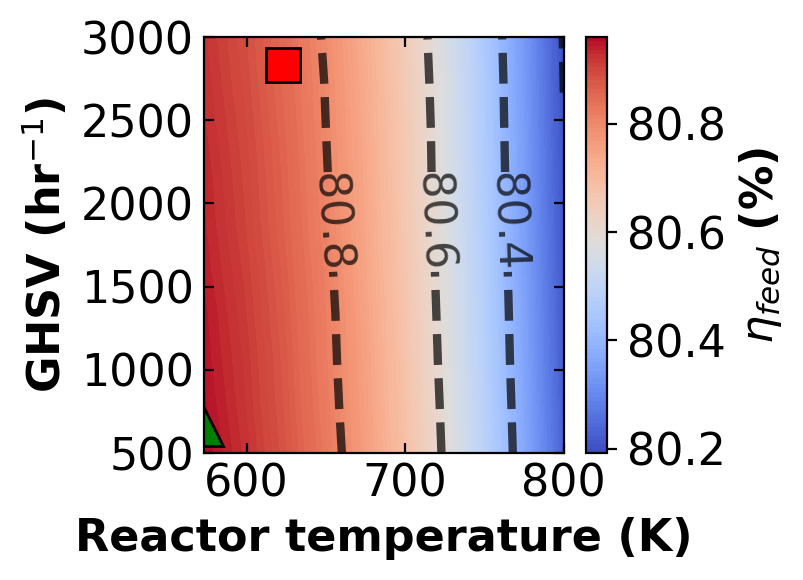

In [17]:
plt.figure(figsize=(4,3),dpi=200)

# Make contour plot
cp = plt.contourf(T_mesh, GHSV_mesh, H2_mesh_plot, cmap=cm.coolwarm, levels=100)


# plot color bar
cbar = plt.colorbar(cp, ticks=np.arange(80.0,90.0,0.2), format='%.1f')

# plot title on color bar
cbar.ax.set_ylabel('$\eta_{feed}$ (%)',fontsize=16,fontweight='bold')


# set font size in color bar
cbar.ax.tick_params(labelsize=16)

# plot equipotential line
cp2 = plt.contour(cp, levels=np.arange(80.0,90.0,0.2), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

# plot the heatmap label
#  %2.2f means keep to 2 digit
#  fontsize defines the size of the text in figure
plt.clabel(cp2, fmt='%.1f', colors='k', fontsize=16) 

# define tick size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)

# set xlimits
#     plt.set_xlim(600,800)
# plt.xlim(600,750)
plt.xticks(np.arange(Tmin+27, Tmax+50, 100))
plt.yticks(np.arange(GHSVmin, GHSVmax+500, 500))

# plot titile and x,y label
plt.xlabel('Reactor temperature (K)', fontsize=16, fontweight='bold')
plt.ylabel('GHSV (hr$^{-1}$)', fontsize=16, fontweight='bold')
# plot base case
plt.plot(base_temperature,base_ghsv,'sr', markersize=12, markeredgecolor='black')
# plot optimal conditions
plt.plot(optimal_temperature,optimal_ghsv,'^g',markersize=14, markeredgecolor='black')


# save figure (important for publications)
if save_fig:
    plt.tight_layout()
    plt.savefig('output/temp_ghsv_sensitivity.png',bbox_inches='tight')
    plt.savefig('output/temp_ghsv_sensitivity.pdf',bbox_inches='tight')
plt.show()

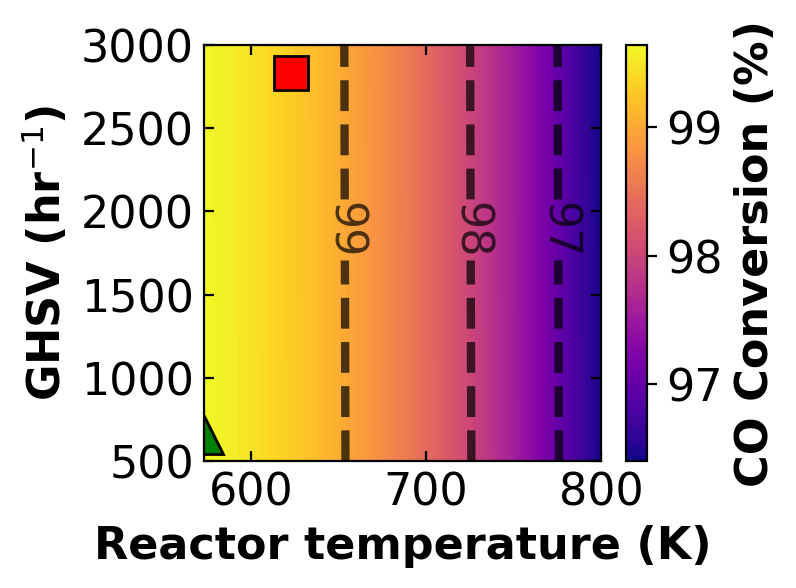

In [18]:
plt.figure(figsize=(4,3),dpi=200)

# Make contour plot
cp = plt.contourf(T_mesh, GHSV_mesh, conversion_plot, cmap=cm.plasma, levels=100)


# plot color bar
cbar = plt.colorbar(cp, ticks=np.arange(96,101,1), ) #format='%d' 

# plot title on color bar
cbar.ax.set_ylabel('CO Conversion (%)',fontsize=16,fontweight='bold')


# set font size in color bar
cbar.ax.tick_params(labelsize=16)

# plot equipotential line
cp2 = plt.contour(cp, levels=np.arange(96,101,1), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

# plot the heatmap label
#  %2.2f means keep to 2 digit
#  fontsize defines the size of the text in figure
plt.clabel(cp2, fmt='%2.0f', colors='k', fontsize=16) 

# define tick size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)

# set xlimits
#     plt.set_xlim(600,800)
# plt.xlim(600,750)
plt.xticks(np.arange(Tmin+27, Tmax+50, 100))
plt.yticks(np.arange(GHSVmin, GHSVmax+500, 500))

# plot titile and x,y label
plt.xlabel('Reactor temperature (K)', fontsize=16, fontweight='bold')
plt.ylabel('GHSV (hr$^{-1}$)', fontsize=16, fontweight='bold')
# plot base case
plt.plot(base_temperature,base_ghsv,'sr', markersize=12, markeredgecolor='black')
# plot optimal conditions
plt.plot(optimal_temperature,optimal_ghsv,'^g', markersize=14, markeredgecolor='black')

# save figure (important for publications)
if save_fig:
    plt.tight_layout()
    plt.savefig('output/conv_ghsv_sensitivity.png',bbox_inches='tight')
    plt.savefig('output/conv_ghsv_sensitivity.pdf',bbox_inches='tight')
plt.show()

In [19]:
np.arange(95.04,95.12,0.02)

array([95.04, 95.06, 95.08, 95.1 ])

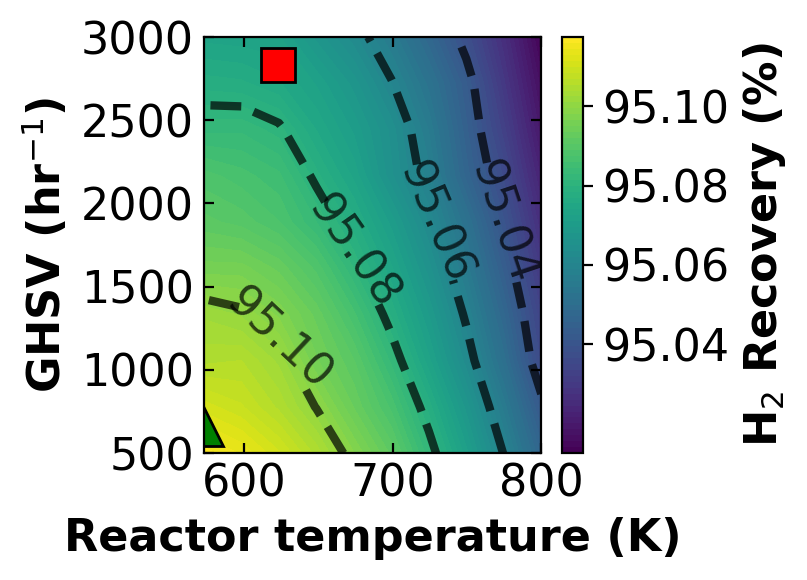

In [20]:
plt.figure(figsize=(4,3),dpi=200)

# Make contour plot
cp = plt.contourf(T_mesh, GHSV_mesh, recovery_plot, cmap=cm.viridis, levels=100)


# plot color bar
cbar = plt.colorbar(cp, ticks=np.arange(95.04,95.12,0.02), format='%.2f') #

# plot title on color bar
cbar.ax.set_ylabel('H$_2$ Recovery (%)',fontsize=16,fontweight='bold')


# set font size in color bar
cbar.ax.tick_params(labelsize=16)

# # plot equipotential line
cp2 = plt.contour(cp, levels=np.arange(95.04,95.12,0.02), colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

# plot the heatmap label
#  %2.2f means keep to 2 digit
#  fontsize defines the size of the text in figure
plt.clabel(cp2, fmt='%.2f', colors='k', fontsize=16) 

# define tick size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)

# set xlimits
#     plt.set_xlim(600,800)
# plt.xlim(600,750)
plt.xticks(np.arange(Tmin+27, Tmax+50, 100))
plt.yticks(np.arange(GHSVmin, GHSVmax+500, 500))

# plot titile and x,y label
plt.xlabel('Reactor temperature (K)', fontsize=16, fontweight='bold')
plt.ylabel('GHSV (hr$^{-1}$)', fontsize=16, fontweight='bold')
# plot base case
plt.plot(base_temperature,base_ghsv,'sr', markersize=12, markeredgecolor='black')
# plot optimal conditions
plt.plot(optimal_temperature,optimal_ghsv,'^g', markersize=14, markeredgecolor='black')


# save figure (important for publications)
if save_fig:
    plt.tight_layout()
    plt.savefig('output/rec_ghsv_sensitivity.png',bbox_inches='tight')
    plt.savefig('output/rec_ghsv_sensitivity.pdf',bbox_inches='tight')
plt.show()